# Project Description:
| This data was extracted from the census bureau database found at
| 
http://www.census.gov/ftp/pub/DES/www/welcome.html

| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.

| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)

| Duplicate or conflicting instances : 6

| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over 50K
| a year.
|
| Conversion of original data as follows:
| 1. Discretized agrossincome into two ranges with threshold 50,000.
| 2. Convert U.S. to US to avoid periods.
| 3. Convert Unknown to "?"
| 4. Run MLC++ GenCVFiles to generate data,test.
|
| Description of fnlwgt (final weight)
|
| The weights on the CPS files are controlled to independent estimates of the
| civilian noninstitutional population of the US.  These are prepared monthly
| for us by Population Division here at the Census Bureau.  We use 3 sets of
| controls.
|  These are:
|          1.  A single cell estimate of the population 16+ for each state.
|          2.  Controls for Hispanic Origin by age and sex.
|          3.  Controls by Race, age and sex.
|
| We use all three sets of controls in our weighting program and "rake" through
| them 6 times so that by the end we come back to all the controls we used.
|
| The term estimate refers to population totals derived from CPS by creating
| "weighted tallies" of any specified socio-economic characteristics of the
| population.
|
| People with similar demographic characteristics should have
| similar weights.  There is one important caveat to remember
| about this statement.  That is that since the CPS sample is
| actually a collection of 51 state samples, each with its own
| probability of selection, the statement only applies within
| state.


## Dataset Link

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [5]:
# Problem 1:
# Prediction task is to determine whether a person makes over 50K a year.

# Problem 2:
# Which factors are important

# Problem 3:
# Which algorithms are best for this dataset

## Solution:


In [1]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile
from io import StringIO

In [7]:
!conda install --yes -c conda-forge missingno

Solving environment: failed

CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/osx-64/repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='conda.anaconda.org', port=443): Read timed out.",),)




In [8]:
!conda install --yes -c anaconda requests

Solving environment: failed

CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/anaconda/osx-64/repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='conda.anaconda.org', port=443): Read timed out.",),)




In [ ]:
!conda update --yes --all

In [2]:
# Data Manipulation 
import numpy as np
import pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

In [5]:
# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

In [6]:
# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [7]:
# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

In [8]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

# Get Data set

In [9]:
# Download
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

In [10]:
# Load Training and Test Data Sets
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']
training_raw = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                       header=None, 
                       names=headers,na_values=["?"])
test_raw = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
                      header=None, 
                      names=headers,na_values=["?"])

In [11]:
# Join Datasets
dataset_raw = training_raw.append(test_raw)
dataset_raw.reset_index(inplace=True)
dataset_raw.drop('index',inplace=True,axis=1)

In [12]:
# Displaying the size of the Dataframe in Memory
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(dataset_raw.memory_usage().sum())

'5.59 MB'

# Exploratory Data Analysis

In [13]:
# Describing all the Numerical Features
dataset_raw.describe()

fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
count  4.884200e+04   48842.000000  48842.000000  48842.000000    48842.000000
mean   1.896641e+05      10.078089   1079.067626     87.502314       40.422382
std    1.056040e+05       2.570973   7452.019058    403.004552       12.391444
min    1.228500e+04       1.000000      0.000000      0.000000        1.000000
25%    1.175505e+05       9.000000      0.000000      0.000000       40.000000
50%    1.781445e+05      10.000000      0.000000      0.000000       40.000000
75%    2.376420e+05      12.000000      0.000000      0.000000       45.000000
max    1.490400e+06      16.000000  99999.000000   4356.000000       99.000000

In [14]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

age workclass education       marital-status       occupation  \
count   48843     48842     48842                48842            48842   
unique    147         9        16                    7               15   
top        36   Private   HS-grad   Married-civ-spouse   Prof-specialty   
freq      898     33906     15784                22379             6172   

       relationship    race    sex  native-country predclass  
count         48842   48842  48842           48842     48842  
unique            6       5      2              42         4  
top         Husband   White   Male   United-States     <=50K  
freq          19716   41762  32650           43832     24720

In [15]:
dataset_raw.head()

age          workclass    fnlwgt   education  education-num  \
0  39          State-gov   77516.0   Bachelors           13.0   
1  50   Self-emp-not-inc   83311.0   Bachelors           13.0   
2  38            Private  215646.0     HS-grad            9.0   
3  53            Private  234721.0        11th            7.0   
4  28            Private  338409.0   Bachelors           13.0   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country predclass  
0        2174.0           0.0            40.0   United-States     <=50K  
1           0.0           0.0            13.0   United-States     <=50K  
2           0.0           0.0            40.0   United-States     <=50K  
3           0.0           0.0            40.0   United-States     <=50K  
4           0.0           0.0            40.0            Cuba     <=50K

In [16]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48843 entries, 0 to 48842
Data columns (total 15 columns):
age               48843 non-null object
workclass         48842 non-null object
fnlwgt            48842 non-null float64
education         48842 non-null object
education-num     48842 non-null float64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null float64
capital-loss      48842 non-null float64
hours-per-week    48842 non-null float64
native-country    48842 non-null object
predclass         48842 non-null object
dtypes: float64(5), object(10)
memory usage: 5.6+ MB


In [17]:
dataset_raw1 = dataset_raw.dropna()

In [18]:
dataset_raw1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
age               48842 non-null object
workclass         48842 non-null object
fnlwgt            48842 non-null float64
education         48842 non-null object
education-num     48842 non-null float64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null float64
capital-loss      48842 non-null float64
hours-per-week    48842 non-null float64
native-country    48842 non-null object
predclass         48842 non-null object
dtypes: float64(5), object(10)
memory usage: 6.0+ MB


In [19]:
dataset_raw = dataset_raw1

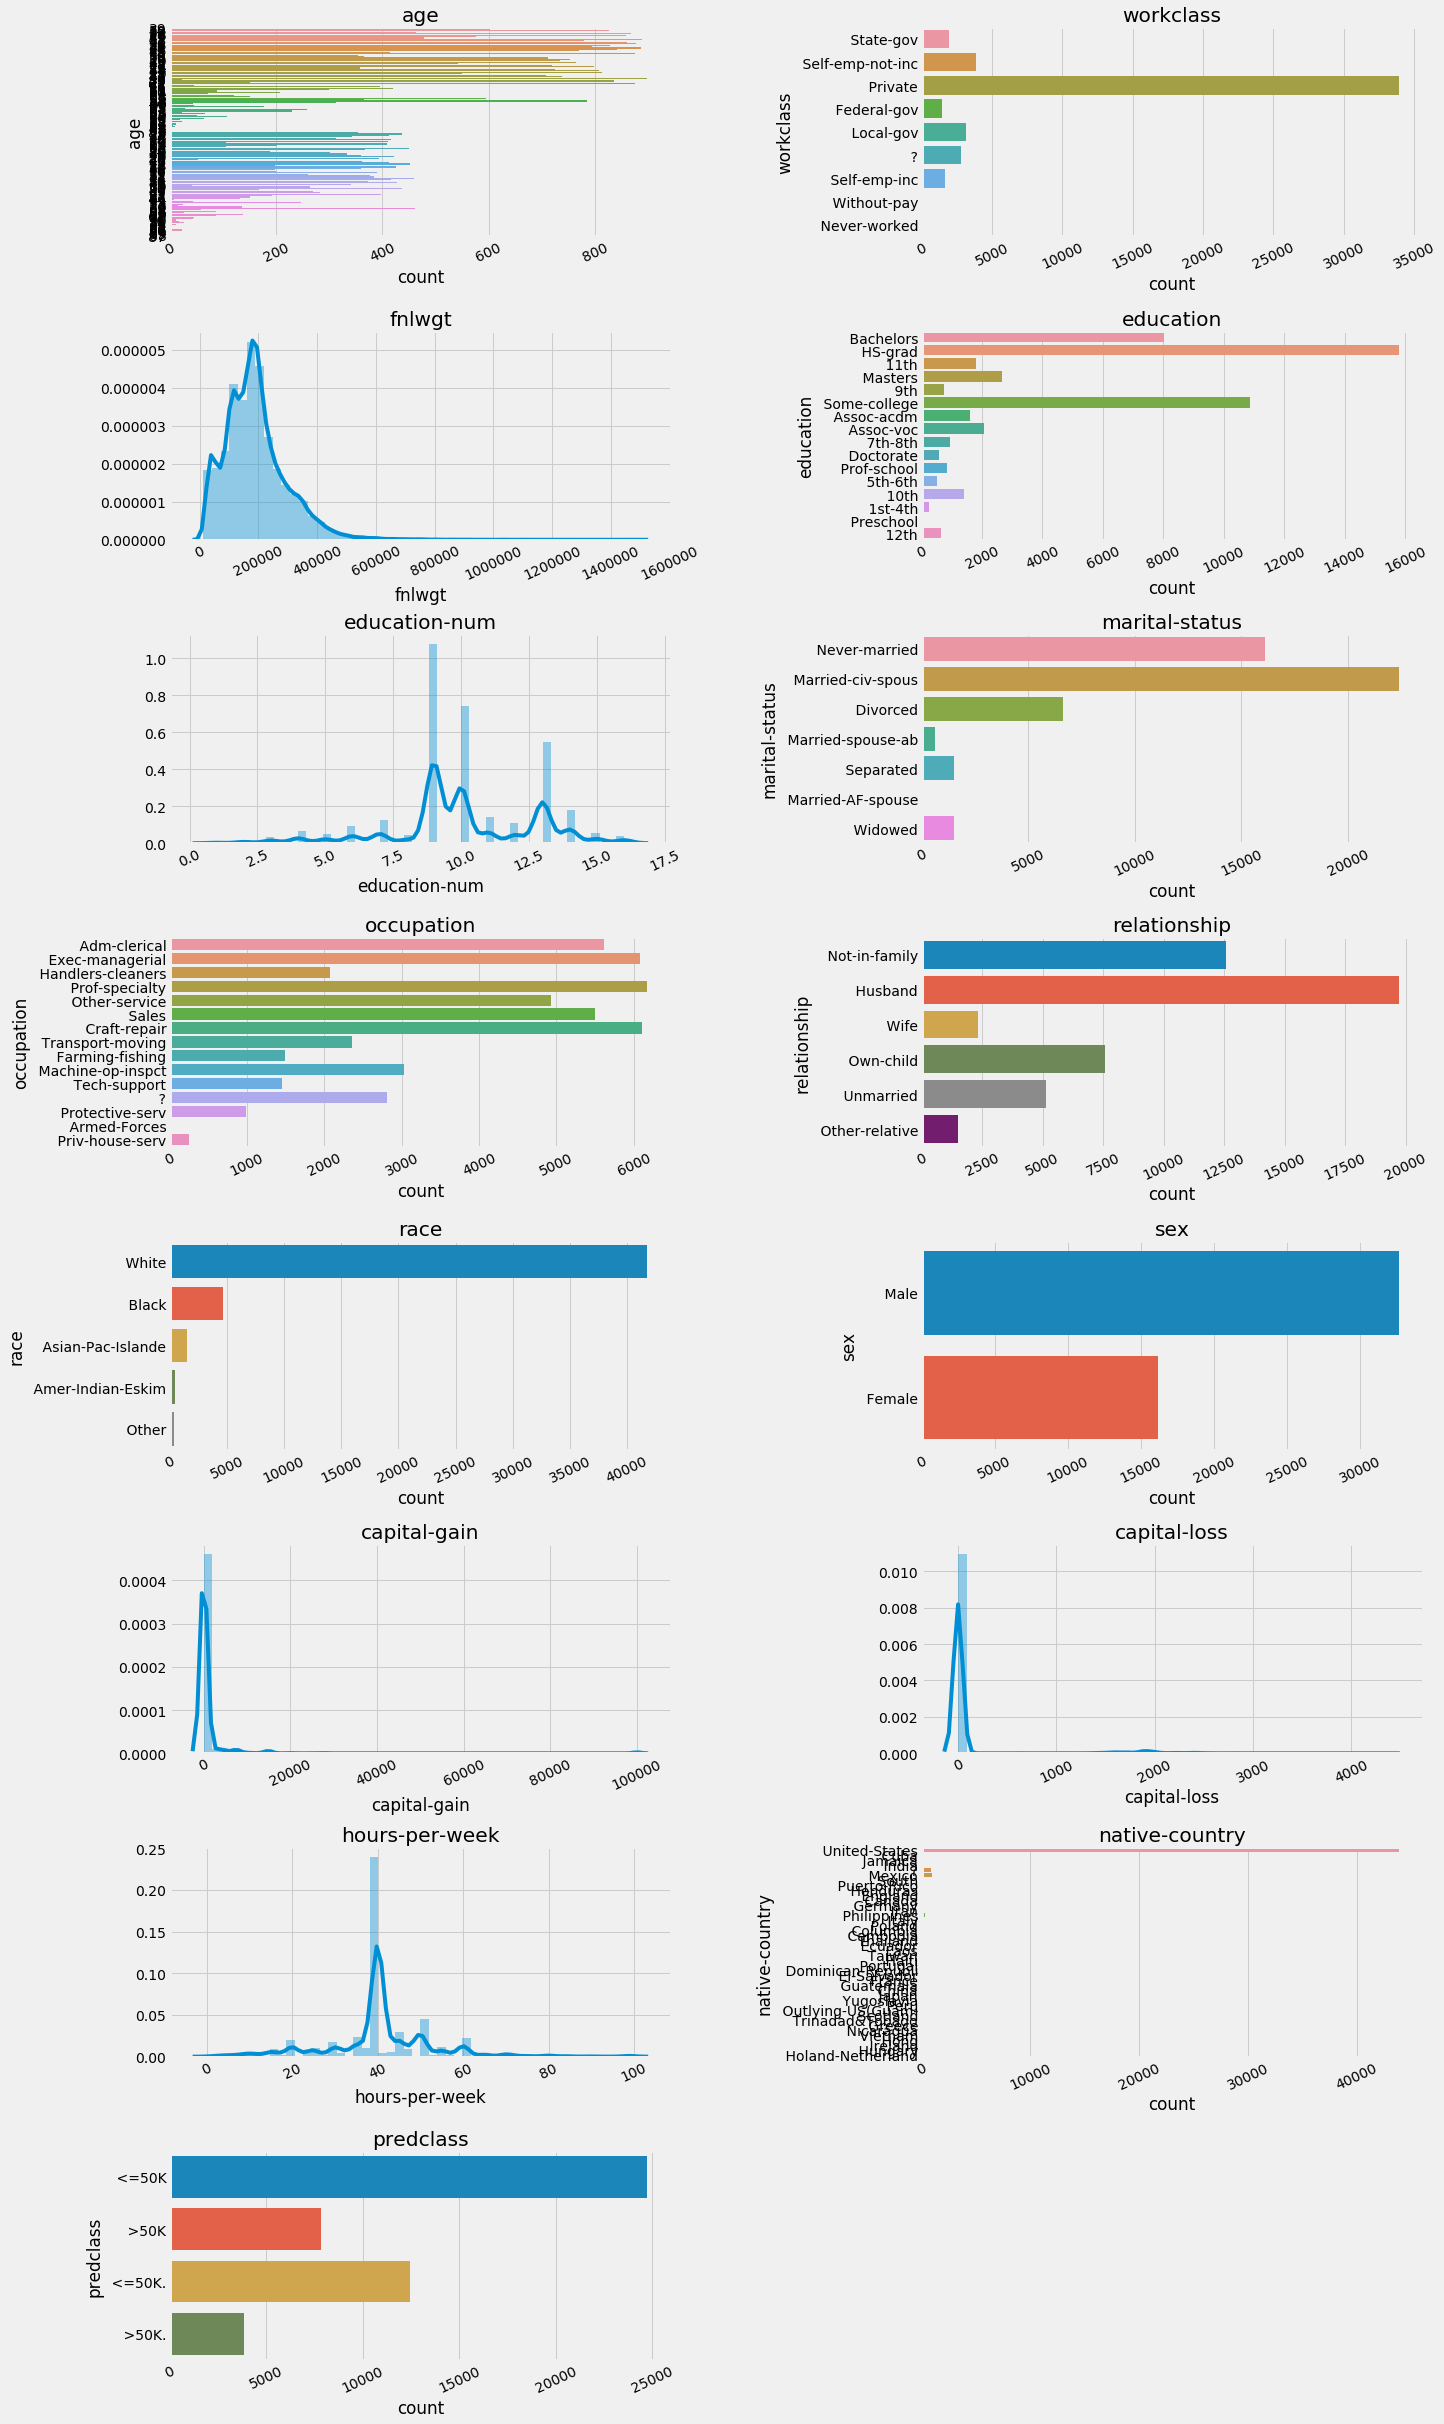

In [20]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dataset_raw, cols=2, width=20, height=40, hspace=0.45, wspace=0.5)

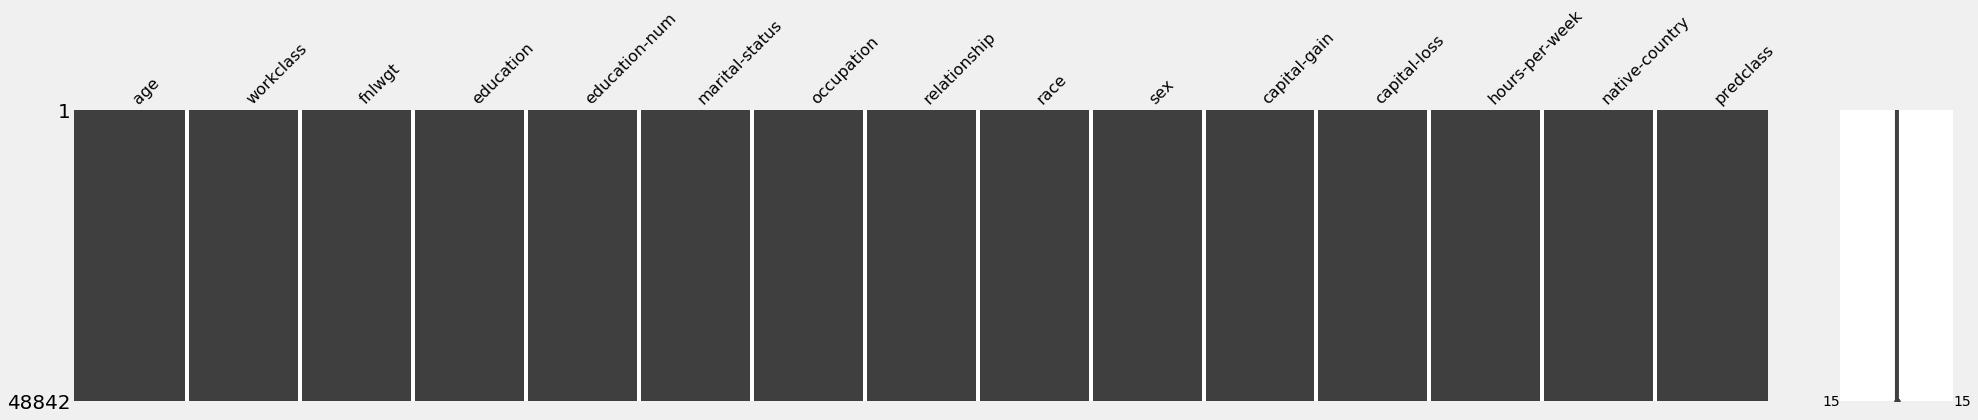

In [21]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize = (30,5))

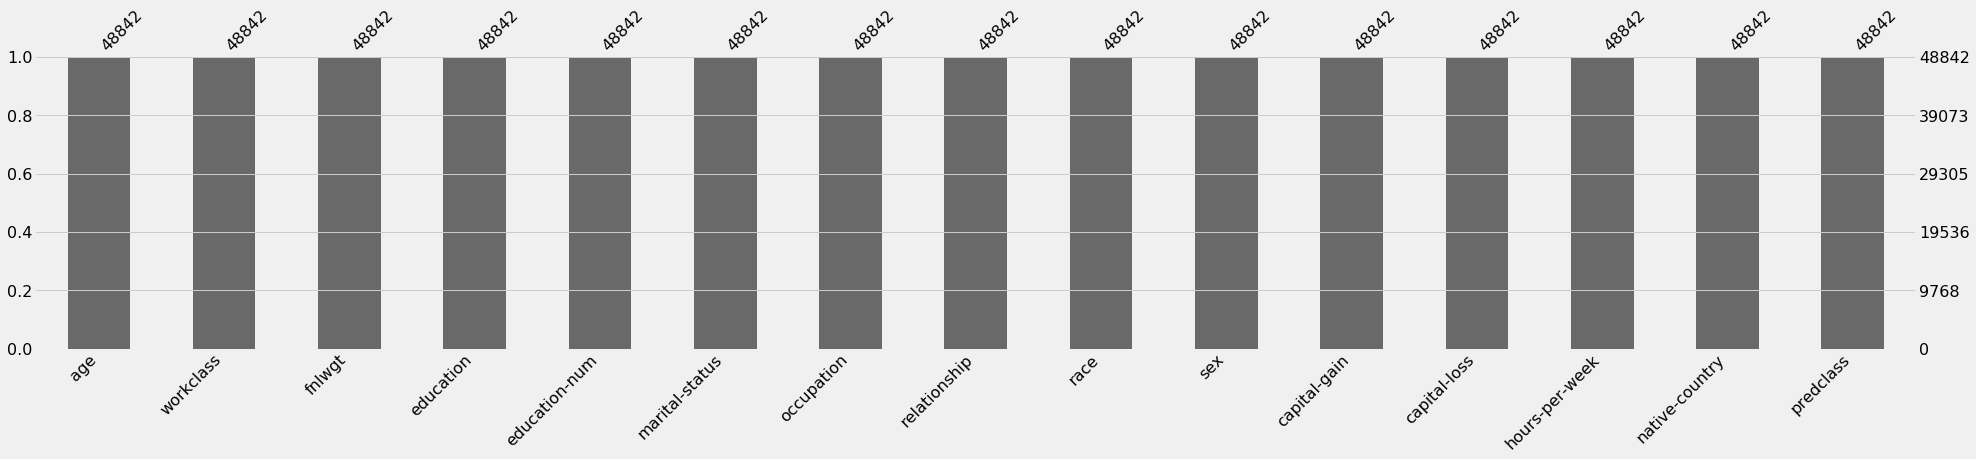

In [22]:
missingno.bar(dataset_raw, sort='ascending', figsize = (30,5))

In [23]:
dataset_bin = pd.DataFrame() # To contain dataframe with discretised continuous variables 
dataset_con = pd.DataFrame() # To contain dataframe with continuous variables 

In [26]:
set(dataset_raw.predclass)

{0, 1}

In [24]:
# Let's recode the Class Feature
dataset_raw.loc[dataset_raw['predclass'] == ' >50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == ' >50K.', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == ' <=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass'] == ' <=50K.', 'predclass'] = 0

In [27]:
(pd.DataFrame(dataset_raw['predclass'].value_counts()).index)

Int64Index([0, 1], dtype='int64')

In [28]:
dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

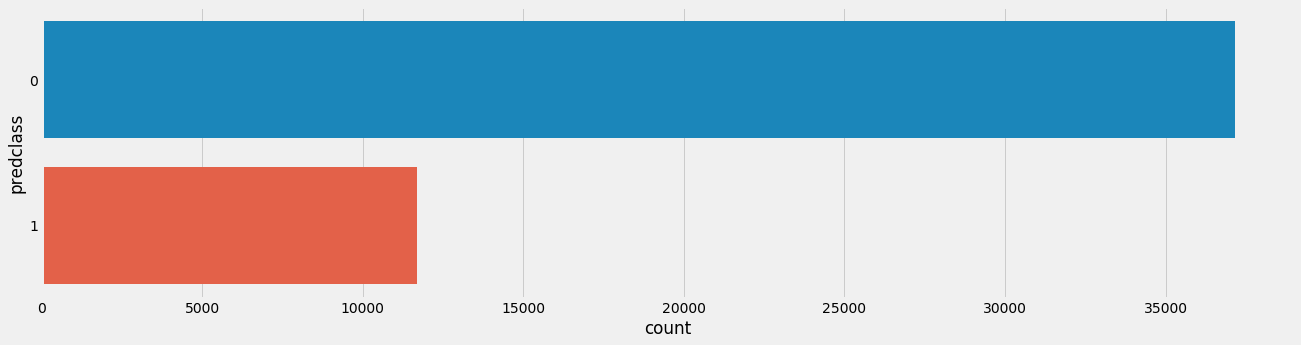

In [29]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="predclass", data=dataset_bin);

In [30]:
dataset_raw.age.value_counts()

36    898
31    888
34    886
23    877
35    876
33    875
28    867
30    861
37    858
25    841
27    835
32    828
38    827
39    816
29    813
41    808
24    798
40    794
26    785
42    780
43    770
22    765
20    753
46    737
45    734
44    724
21    720
19    712
47    708
50    602
     ... 
90     43
69     41
77     29
75     27
74     26
77     25
76     23
78     23
79     22
80     22
81     20
81     17
80     16
82     12
90     12
78     11
84     10
79      8
83      6
83      5
84      3
85      3
88      3
82      3
88      3
87      2
89      2
85      2
86      1
87      1
Name: age, Length: 146, dtype: int64

In [31]:
dataset_raw.age = dataset_raw.age.astype(float)

In [32]:
dataset_bin['age'] = pd.cut(dataset_raw['age'], 10) # discretised 

In [33]:
dataset_con['age'] = dataset_raw['age'] # non-discretised

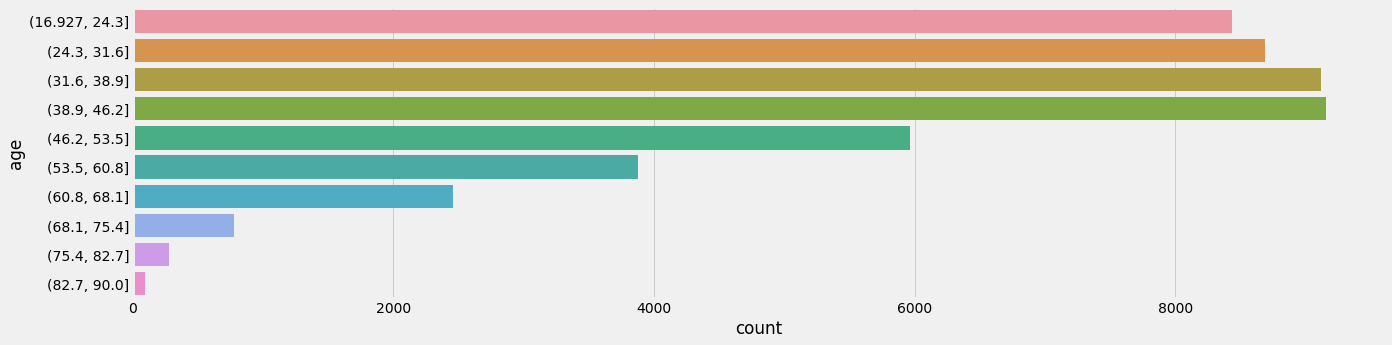

In [34]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="age", data=dataset_bin);

In [35]:
dataset_con.head()

predclass   age
0          0  39.0
1          0  50.0
2          0  38.0
3          0  53.0
4          0  28.0

In [36]:
dataset_raw.head()

age          workclass    fnlwgt   education  education-num  \
0  39.0          State-gov   77516.0   Bachelors           13.0   
1  50.0   Self-emp-not-inc   83311.0   Bachelors           13.0   
2  38.0            Private  215646.0     HS-grad            9.0   
3  53.0            Private  234721.0        11th            7.0   
4  28.0            Private  338409.0   Bachelors           13.0   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  predclass  
0        2174.0           0.0            40.0   United-States          0  
1           0.0           0.0            13.0   United-States          0  
2           0.0           0.0            40.0   United-States          0  
3           0.0           0.0            40.0   United-States          0  
4           0.0           0.0            40.0            Cuba          0

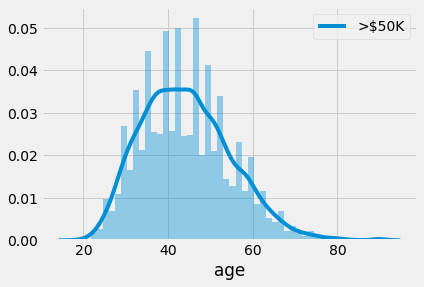

In [37]:
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"});

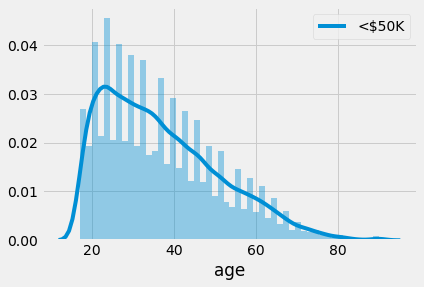

In [38]:
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"});

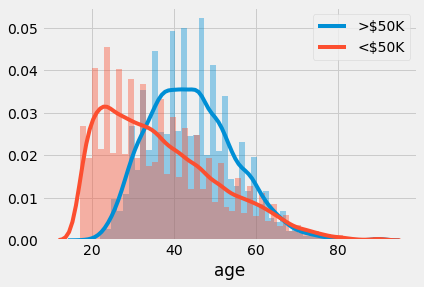

In [39]:
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"});

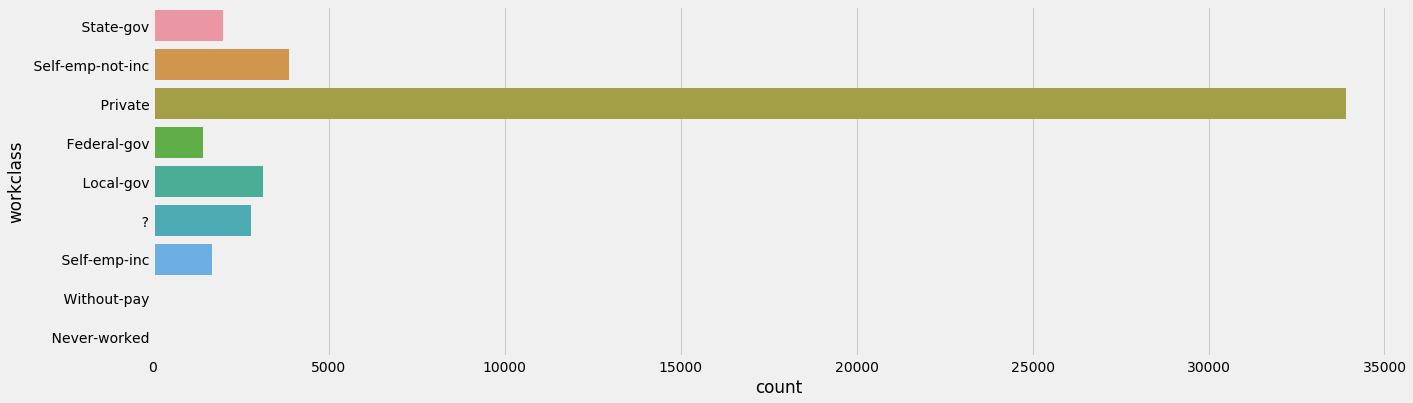

In [40]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,6)) 
sns.countplot(y="workclass", data=dataset_raw);

In [41]:
# Create buckets for Workclass
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

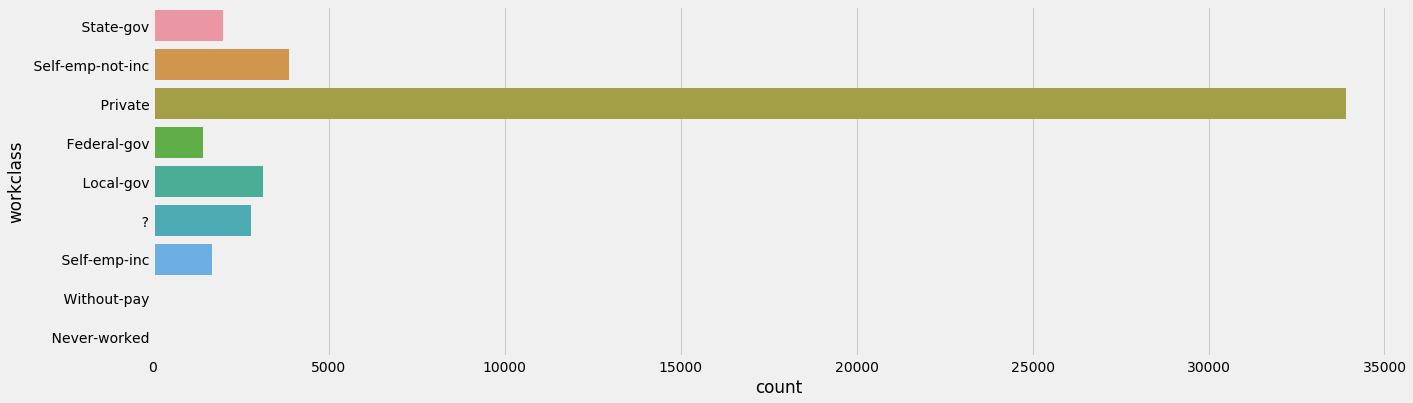

In [42]:
fig = plt.figure(figsize=(20,6)) 
sns.countplot(y="workclass", data=dataset_bin);

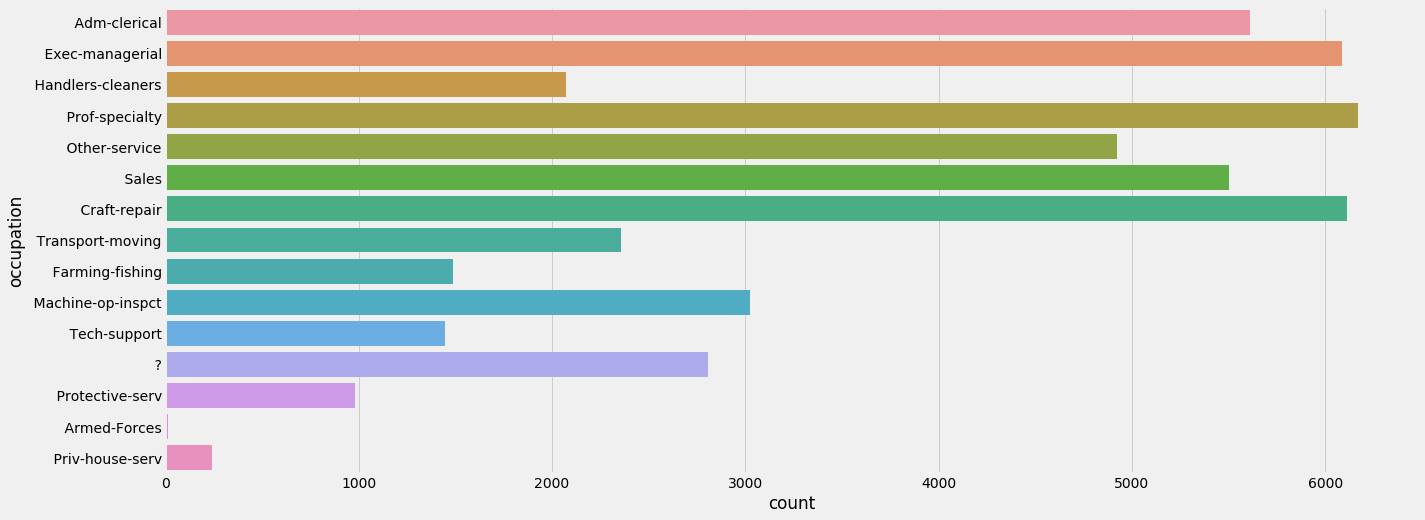

In [43]:
plt.figure(figsize=(20,8)) 
sns.countplot(y="occupation", data=dataset_raw);

In [44]:
# Create buckets for Occupation
dataset_raw.loc[dataset_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

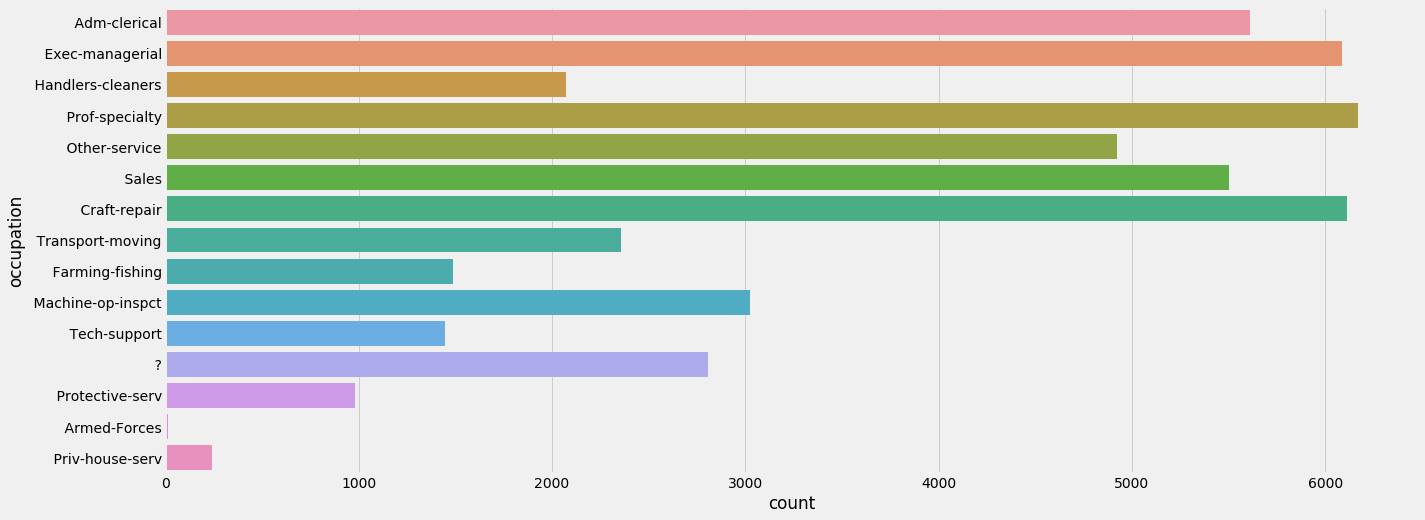

In [45]:
fig = plt.figure(figsize=(20,8))
sns.countplot(y="occupation", data=dataset_bin);

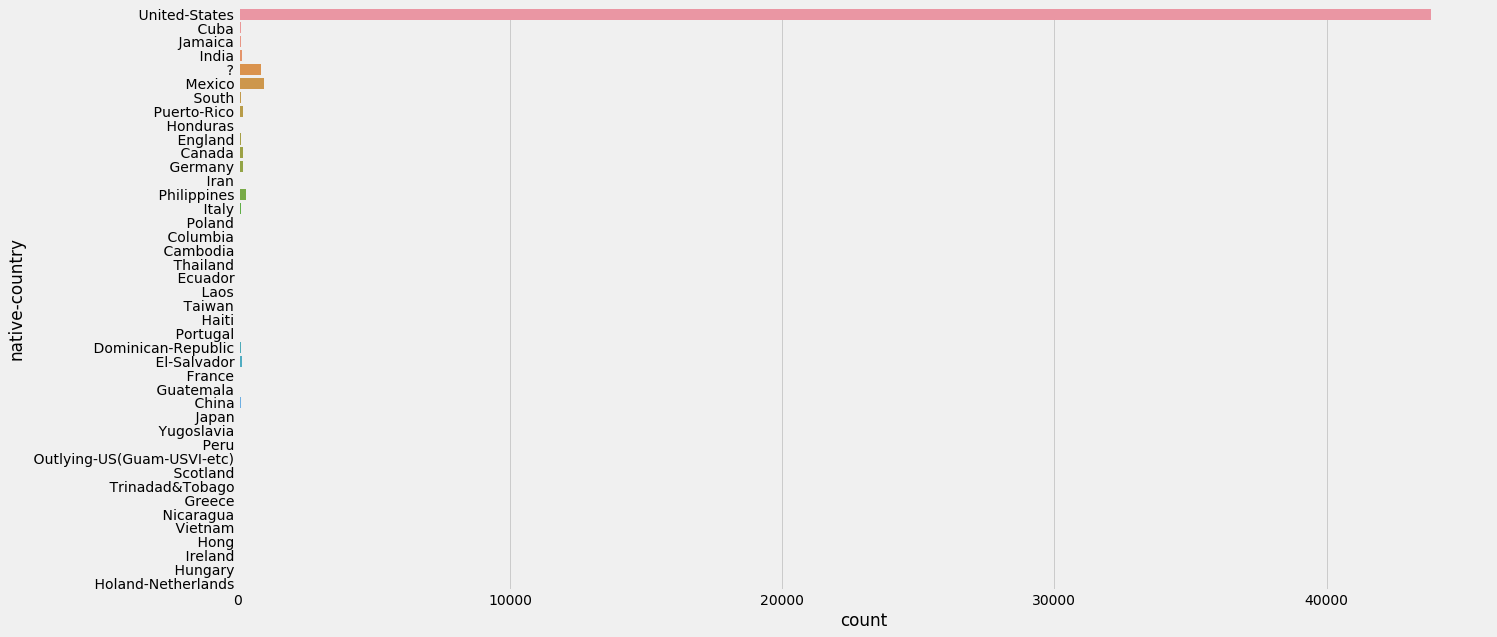

In [46]:
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=dataset_raw);

In [47]:
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

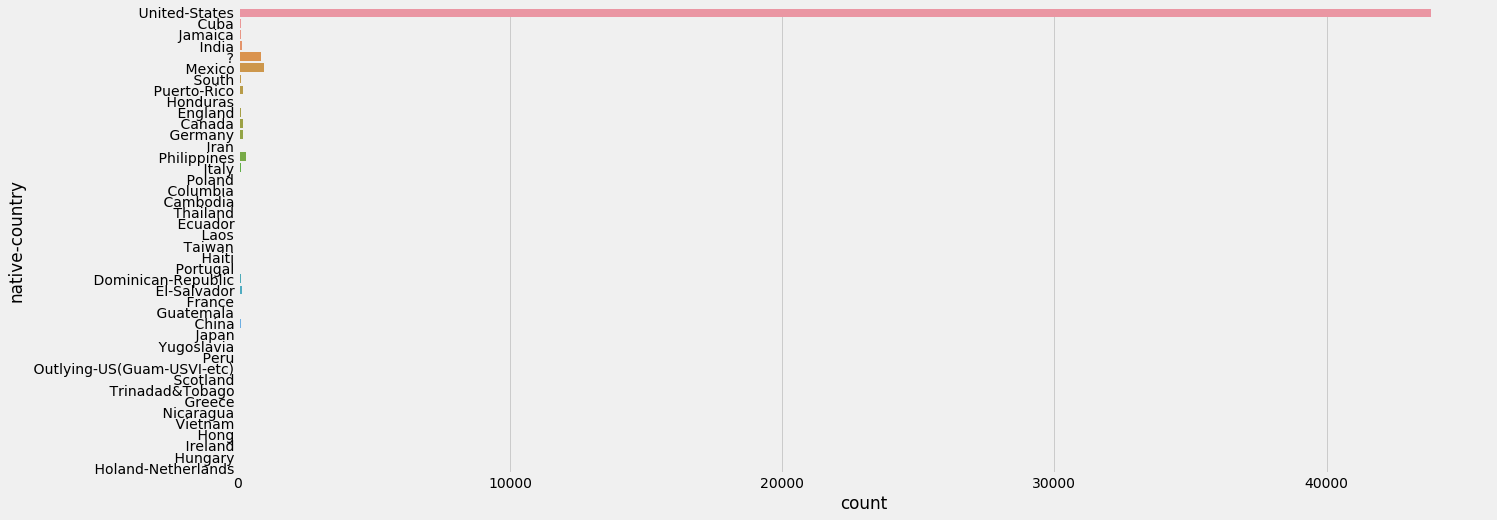

In [48]:
fig = plt.figure(figsize=(20,8)) 
sns.countplot(y="native-country", data=dataset_bin);

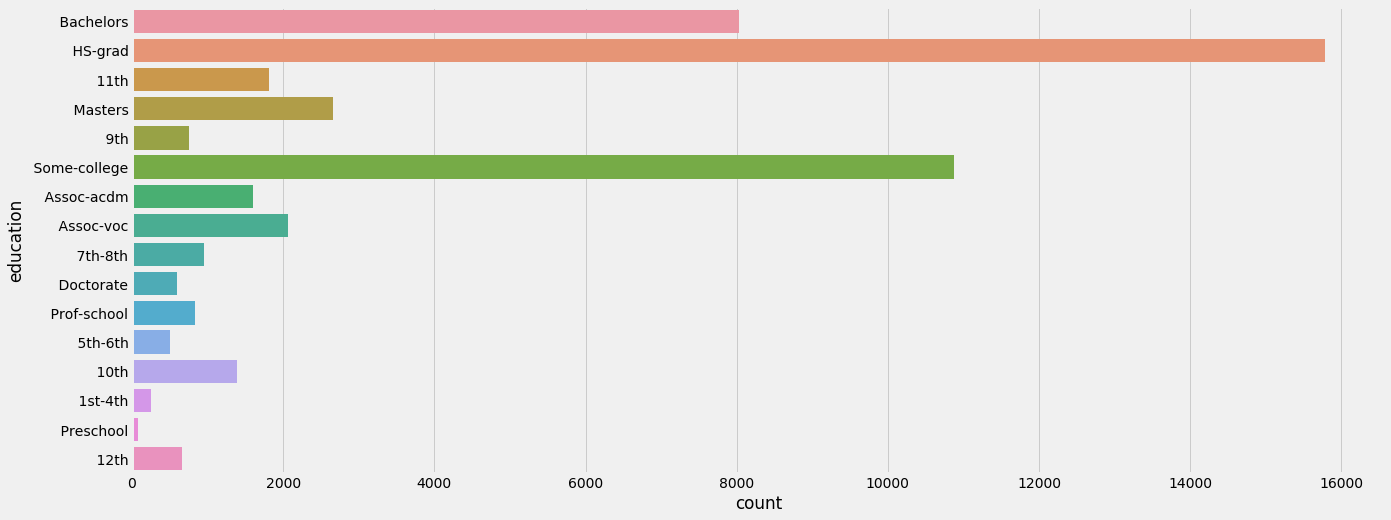

In [49]:
plt.figure(figsize=(20,8)) 
sns.countplot(y="education", data=dataset_raw);

In [50]:
dataset_raw.loc[dataset_raw['education'] == '10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == 'Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

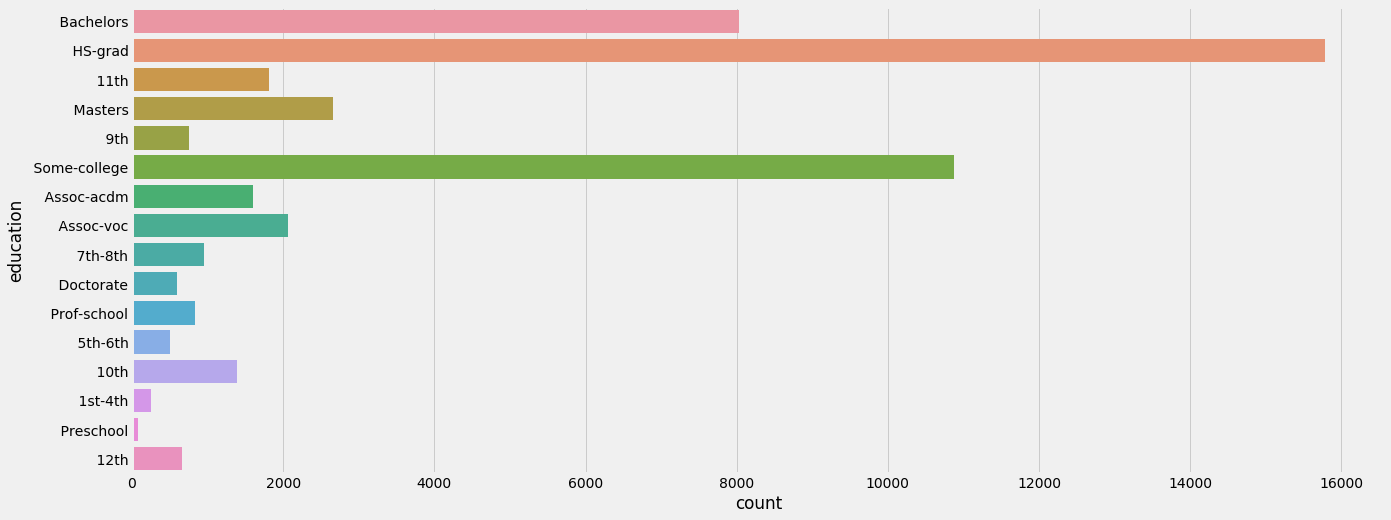

In [51]:
fig = plt.figure(figsize=(20,8)) 
sns.countplot(y="education", data=dataset_bin);

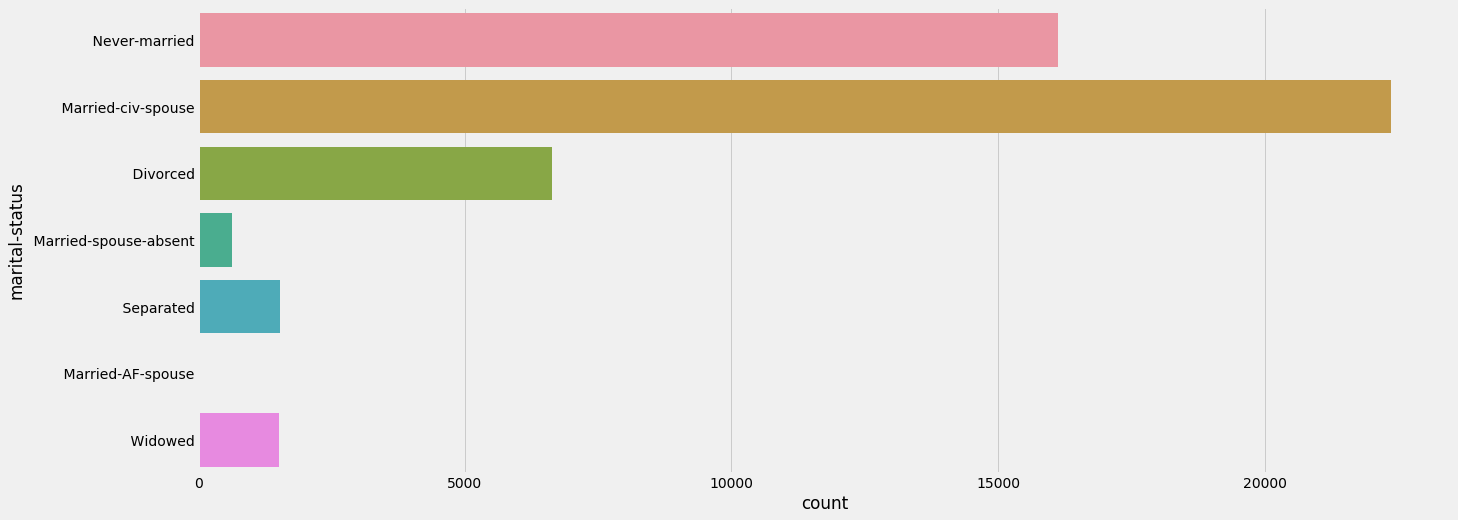

In [52]:
plt.figure(figsize=(20,8)) 
sns.countplot(y="marital-status", data=dataset_raw);

In [53]:
dataset_raw.loc[dataset_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

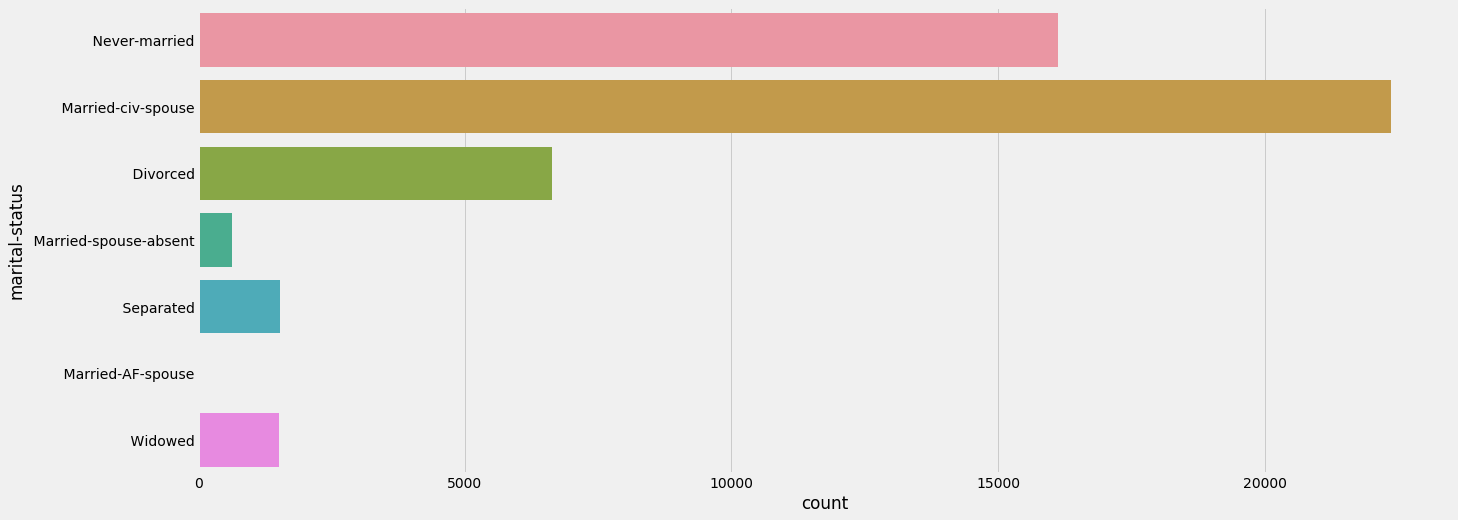

In [54]:
fig = plt.figure(figsize=(20,8)) 
sns.countplot(y="marital-status", data=dataset_bin);

In [55]:
# use Cut function to bin the data in equally sized buckets
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

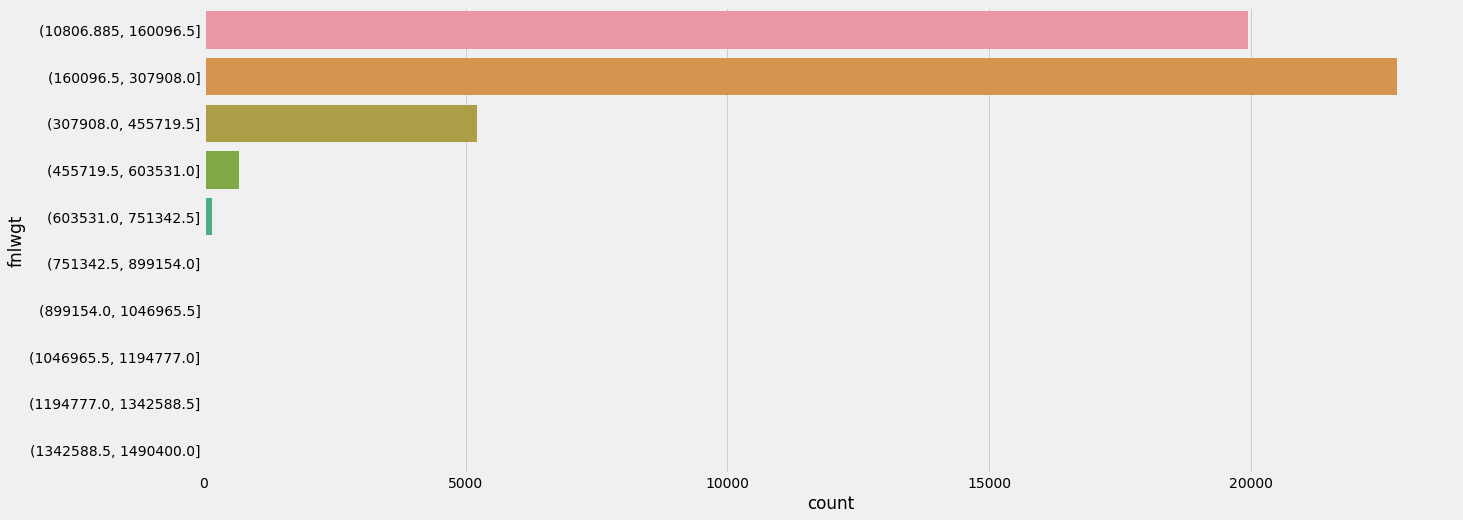

In [56]:
fig = plt.figure(figsize=(20,8)) 
sns.countplot(y="fnlwgt", data=dataset_bin);

In [57]:
# use the Cut function to bin the data in equally sized buckets
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num'] = dataset_raw['education-num']

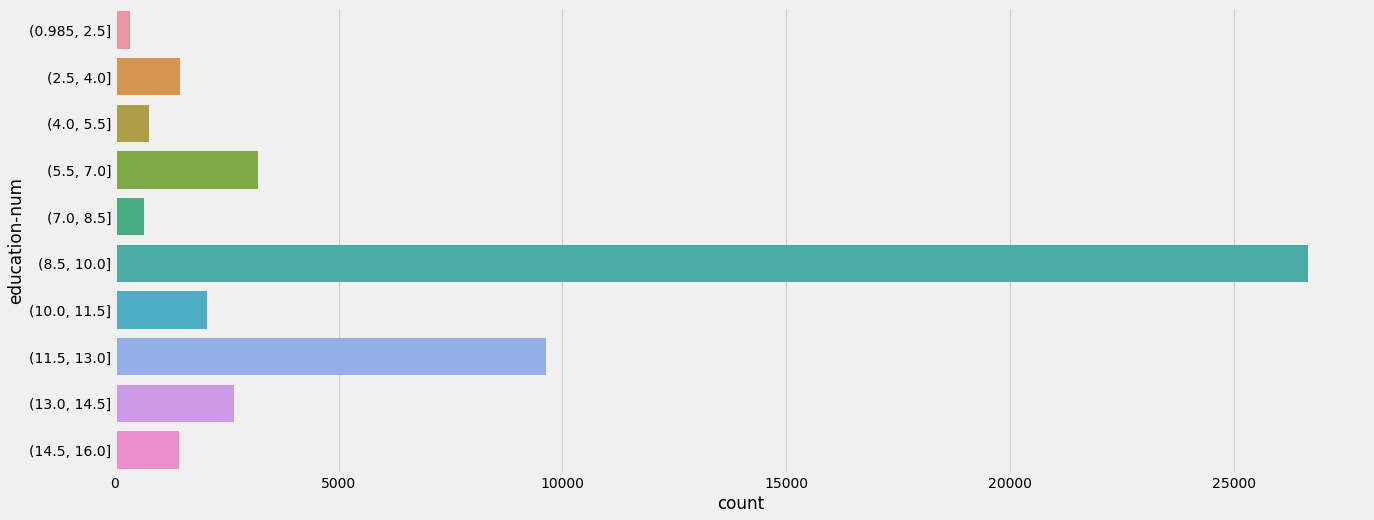

In [58]:
fig = plt.figure(figsize=(20,8)) 
sns.countplot(y="education-num", data=dataset_bin);

In [59]:
# use Cut function to bin the data in equally sized buckets
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

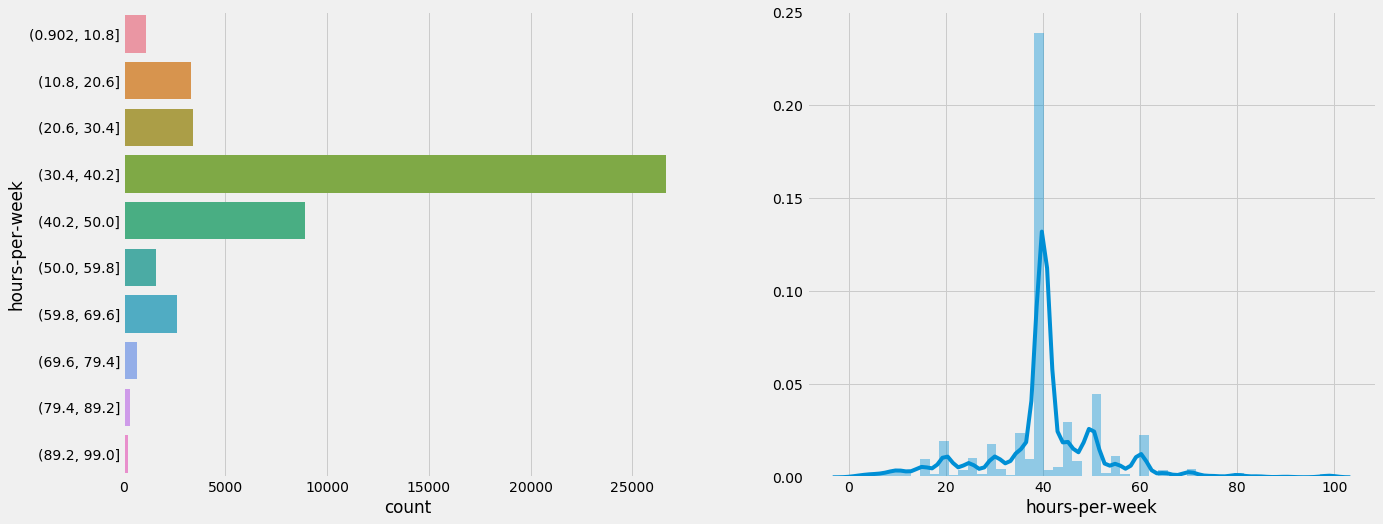

In [60]:
fig = plt.figure(figsize=(20,8)) 
plt.subplot(1, 2, 1)
sns.countplot(y="hours-per-week", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['hours-per-week']);

In [61]:
# use the Cut function to bin the data in equally sized buckets
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']


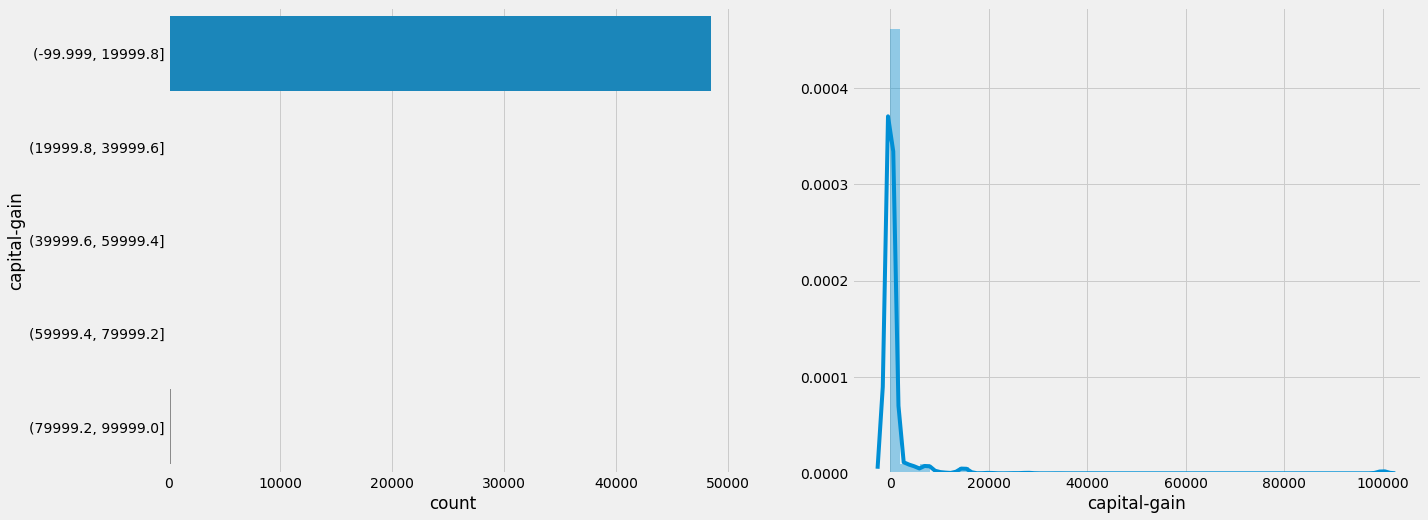

In [62]:
fig = plt.figure(figsize=(20,8)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain']);

In [63]:
# use the Cut function to bin the data in equally sized buckets
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']


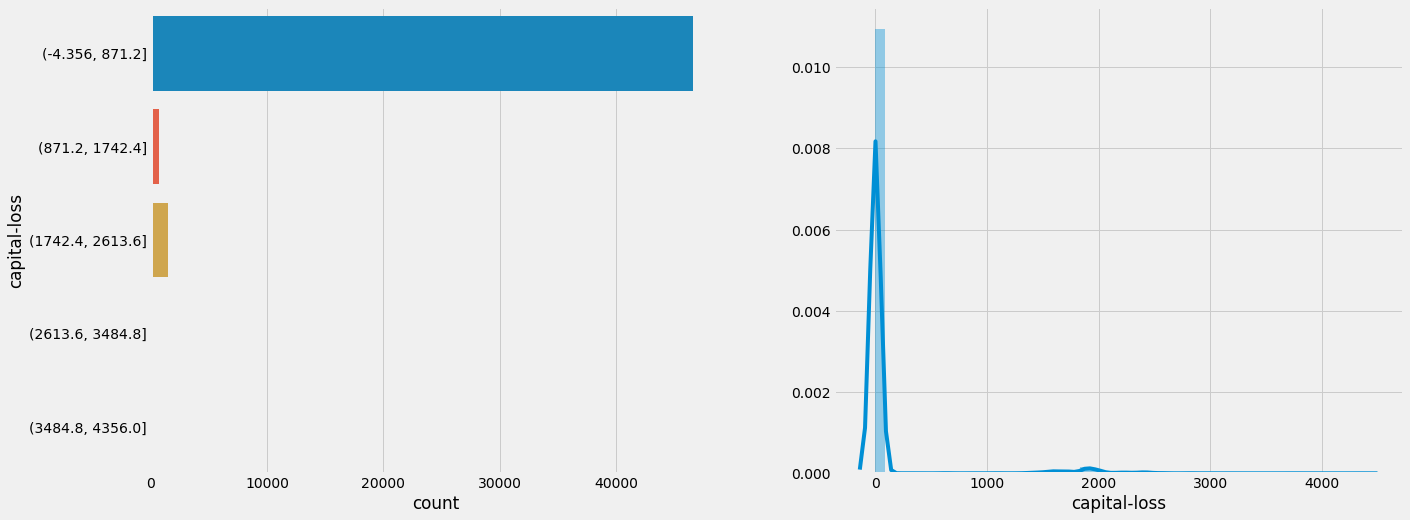

In [64]:
fig = plt.figure(figsize=(20,8)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss']);

In [65]:
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

In [67]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
age               48842 non-null float64
workclass         48842 non-null object
fnlwgt            48842 non-null float64
education         48842 non-null object
education-num     48842 non-null float64
marital-status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital-gain      48842 non-null float64
capital-loss      48842 non-null float64
hours-per-week    48842 non-null float64
native-country    48842 non-null object
predclass         48842 non-null int64
dtypes: float64(6), int64(1), object(8)
memory usage: 7.2+ MB


In [68]:
dataset_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
predclass         48842 non-null int64
age               48842 non-null category
workclass         48842 non-null object
occupation        48842 non-null object
native-country    48842 non-null object
education         48842 non-null object
marital-status    48842 non-null object
fnlwgt            48842 non-null category
education-num     48842 non-null category
hours-per-week    48842 non-null category
capital-gain      48842 non-null category
capital-loss      48842 non-null category
sex               48842 non-null object
race              48842 non-null object
relationship      48842 non-null object
dtypes: category(6), int64(1), object(8)
memory usage: 5.3+ MB


In [69]:
dataset_con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
predclass         48842 non-null int64
age               48842 non-null float64
workclass         48842 non-null object
occupation        48842 non-null object
native-country    48842 non-null object
education         48842 non-null object
marital-status    48842 non-null object
fnlwgt            48842 non-null float64
education-num     48842 non-null float64
hours-per-week    48842 non-null float64
capital-gain      48842 non-null float64
capital-loss      48842 non-null float64
sex               48842 non-null object
race              48842 non-null object
relationship      48842 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 6.0+ MB


In [75]:
dataset_con['predclass'] = pd.Categorical(dataset_con['predclass'])

In [76]:
dataset_con.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 48842
Data columns (total 15 columns):
predclass         48842 non-null category
age               48842 non-null float64
workclass         48842 non-null object
occupation        48842 non-null object
native-country    48842 non-null object
education         48842 non-null object
marital-status    48842 non-null object
fnlwgt            48842 non-null float64
education-num     48842 non-null float64
hours-per-week    48842 non-null float64
capital-gain      48842 non-null float64
capital-loss      48842 non-null float64
sex               48842 non-null object
race              48842 non-null object
relationship      48842 non-null object
dtypes: category(1), float64(6), object(8)
memory usage: 6.9+ MB


In [78]:
type(dataset_con.predclass)

pandas.core.series.Series

In [80]:
set(dataset_raw.predclass)

{0, 1}

## Bi-variate Analysis

In [70]:
# Plot a count of the categories from each categorical feature split by prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)

In [81]:
# plot_bivariate_bar(dataset_con, hue='predclass', cols=2, width=20, height=40, hspace=0.4, wspace=0.5)

# replace the integer values 0, 1 into categorical values such as "yes", "no"

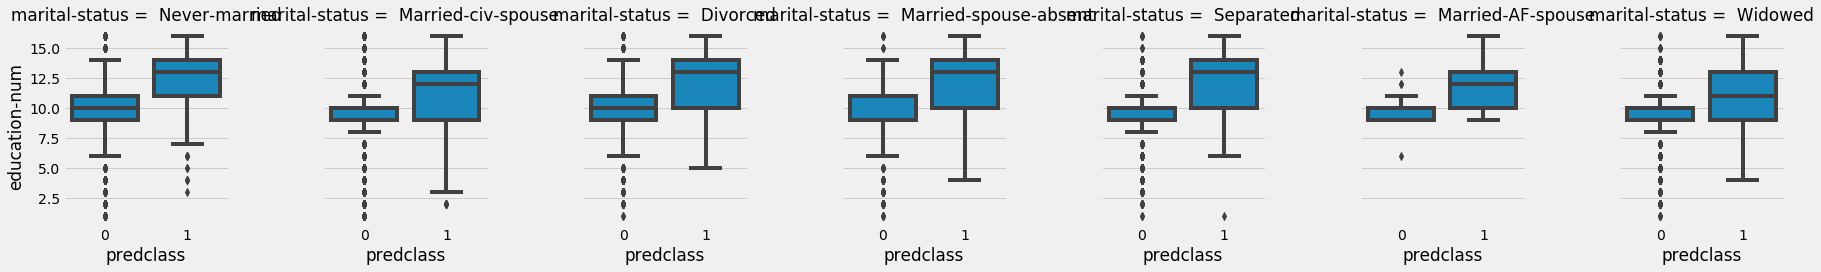

In [82]:
# Effect of Marital Status and Education on Income, across Marital Status.
plt.style.use('fivethirtyeight')
g = sns.FacetGrid(dataset_con, col='marital-status', size=4, aspect=.9)
g = g.map(sns.boxplot, 'predclass', 'education-num')

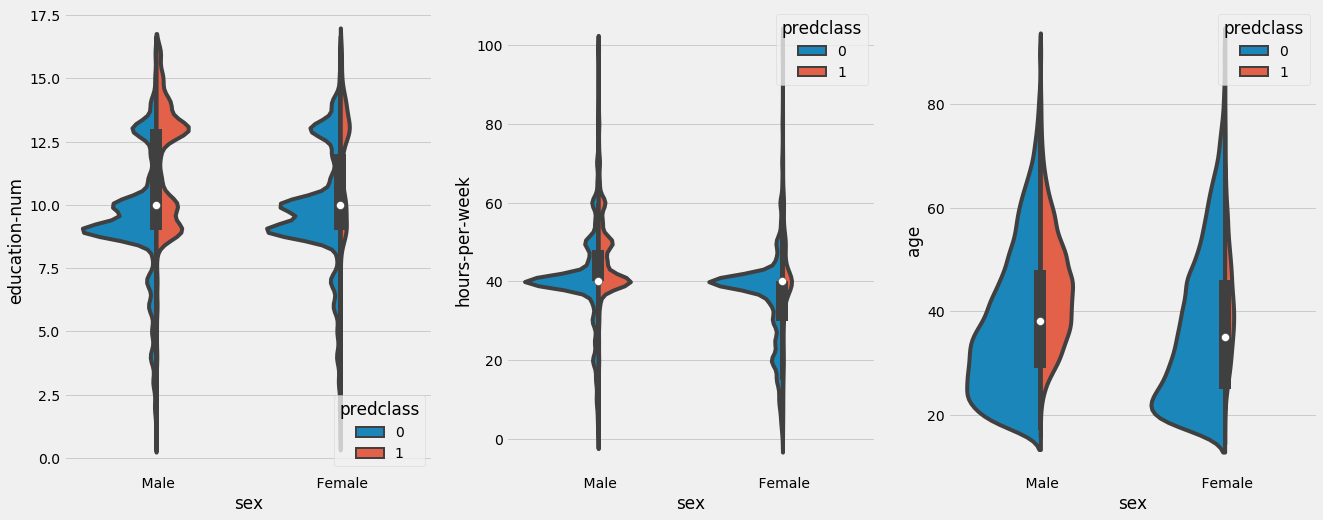

In [83]:
# Trends on the Sex, Education, HPW and Age impact on Income.
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,8)) 
plt.subplot(1, 3, 1)
sns.violinplot(x='sex', y='education-num', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='hours-per-week', hue='predclass', data=dataset_con, split=True, scale='count');

plt.subplot(1, 3, 3)
sns.violinplot(x='sex', y='age', hue='predclass', data=dataset_con, split=True, scale='count');

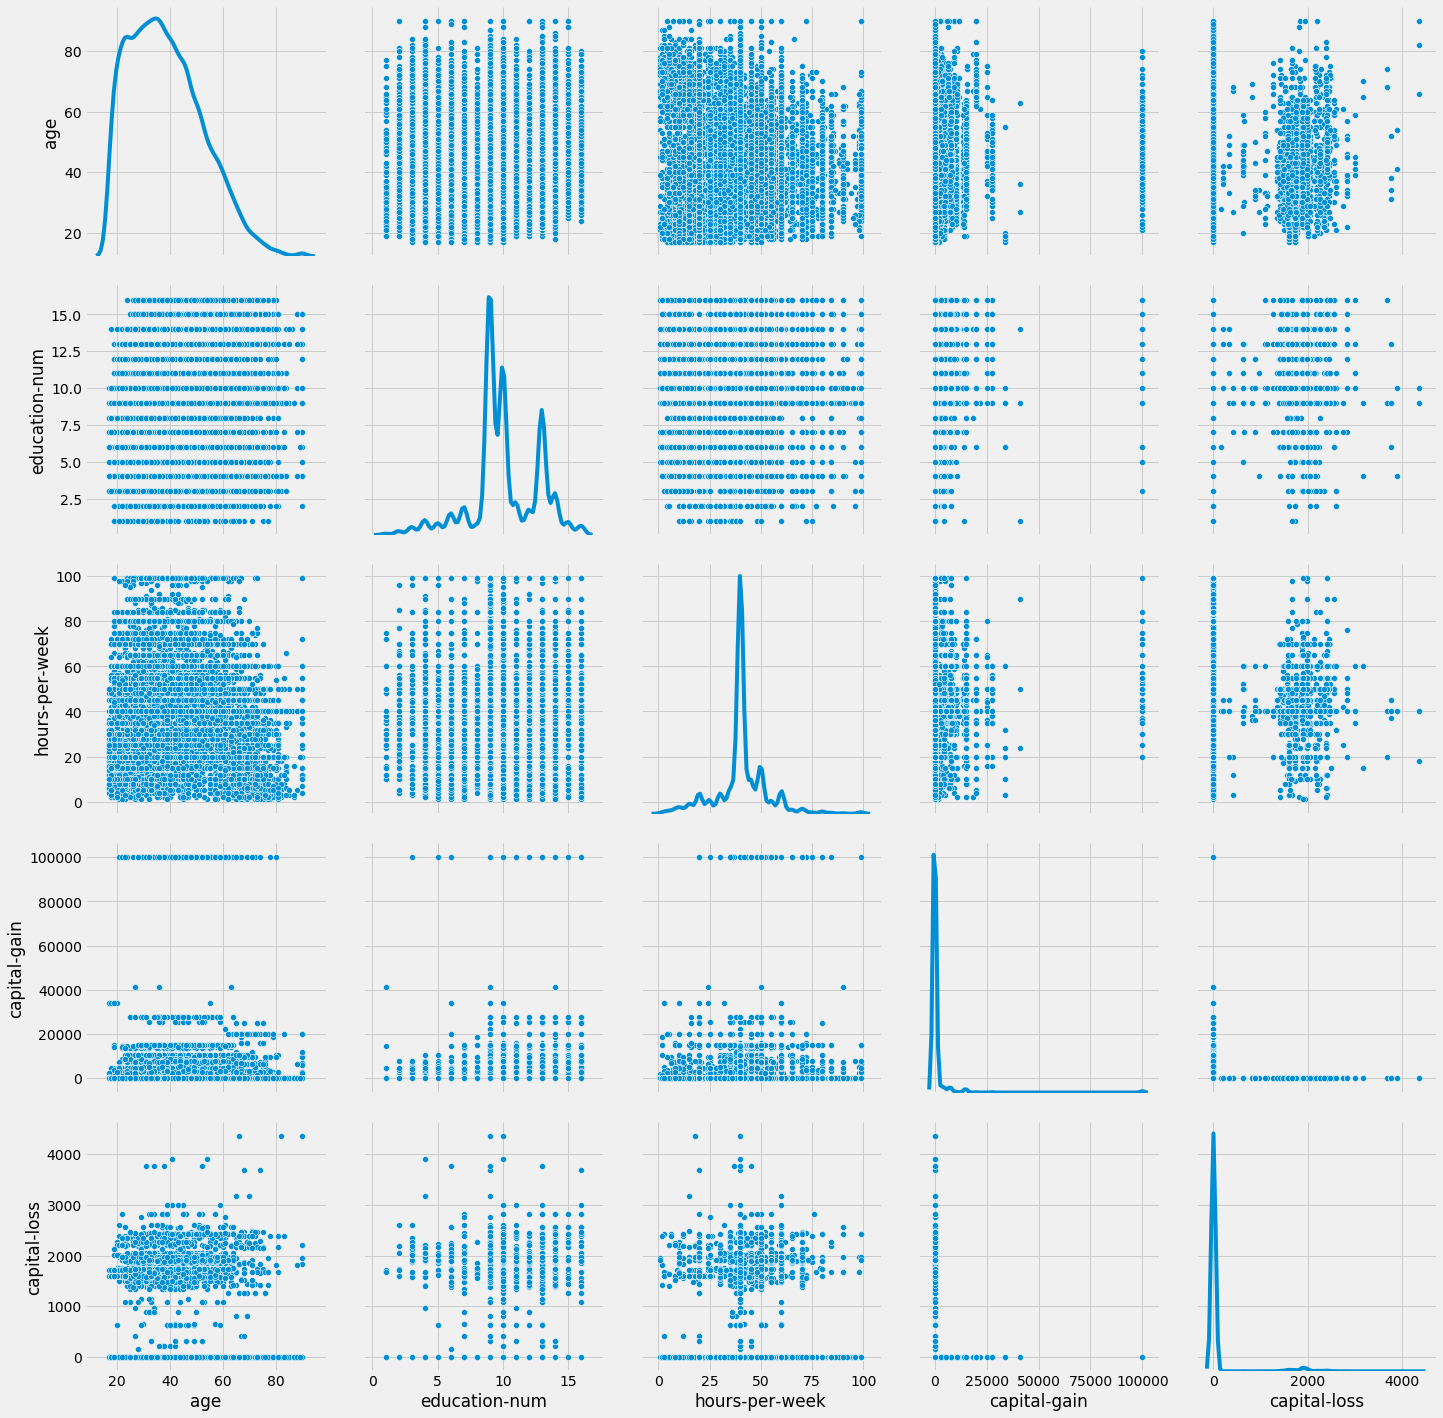

In [86]:
# Interaction between pairs of features.
sns.pairplot(dataset_con[['age','education-num','hours-per-week','capital-gain','capital-loss']], 
             diag_kind="kde",
             size=4);

In [87]:
# creating interaction features
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

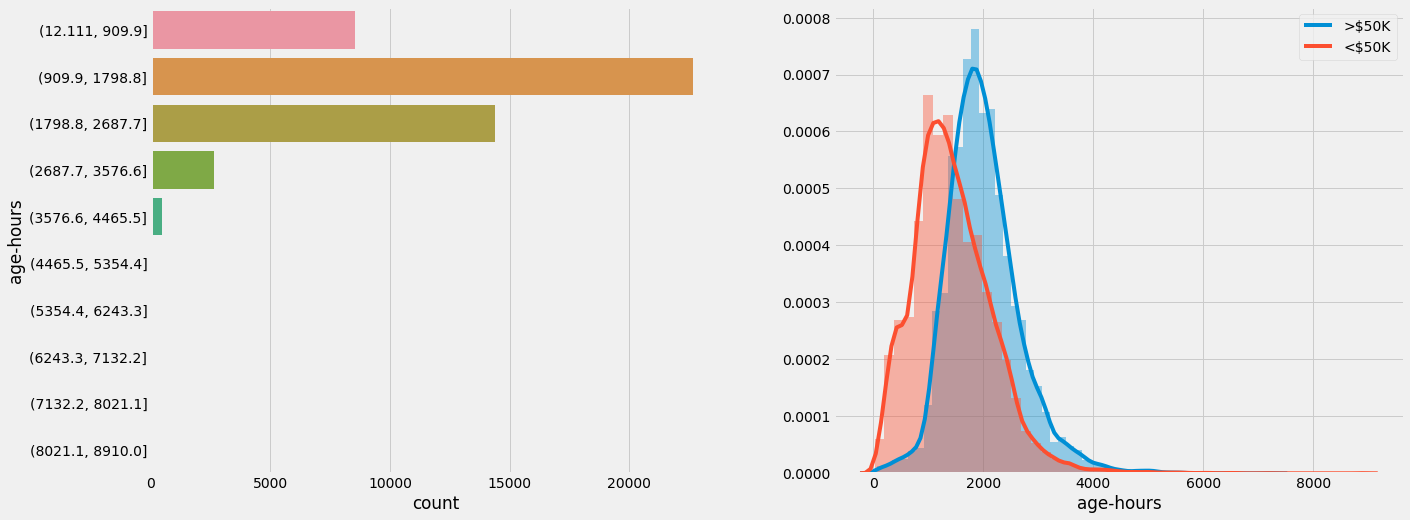

In [88]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,8)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'], kde_kws={"label": "<$50K"});

In [89]:
#creating interaction features between categorical variables
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

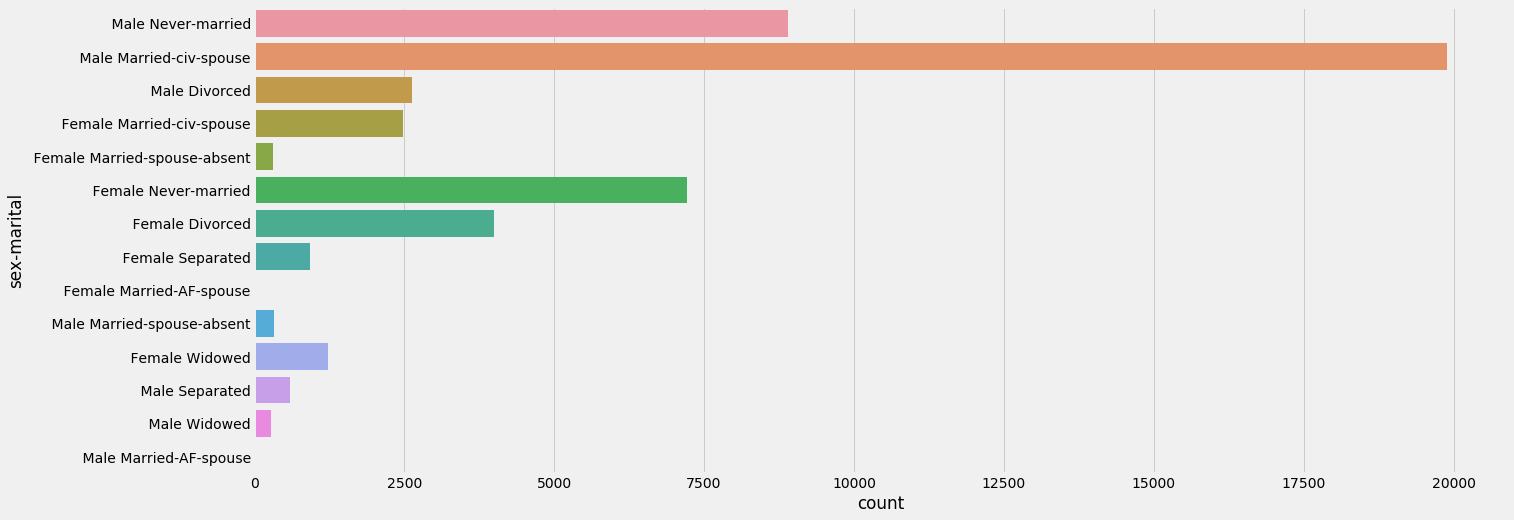

In [90]:
fig = plt.figure(figsize=(20,8)) 
sns.countplot(y="sex-marital", data=dataset_bin);

In [91]:
# One Hot Encoded (dummy variable creation) for all labels before performing Machine Learning
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('predclass')
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

predclass  age_(16.927, 24.3]  age_(24.3, 31.6]  age_(31.6, 38.9]  \
0          0                   0                 0                 0   
1          0                   0                 0                 0   
2          0                   0                 0                 1   
3          0                   0                 0                 0   
4          0                   0                 1                 0   

   age_(38.9, 46.2]  age_(46.2, 53.5]  age_(53.5, 60.8]  age_(60.8, 68.1]  \
0                 1                 0                 0                 0   
1                 0                 1                 0                 0   
2                 0                 0                 0                 0   
3                 0                 1                 0                 0   
4                 0                 0                 0                 0   

   age_(68.1, 75.4]  age_(75.4, 82.7]            ...              \
0                 0                 0            ...               
1                 0                 0            ...               
2                 0                 0            ...               
3                 0                 0            ...               
4                 0                 0            ...               

   sex-marital_ Female Never-married  sex-marital_ Female Separated  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   

   sex-marital_ Female Widowed  sex-marital_ Male Divorced  \
0                            0                           0   
1                            0                           0   
2                            0                           1   
3                            0                           0   
4                            0                           0   

   sex-marital_ Male Married-AF-spouse  sex-marital_ Male Married-civ-spouse  \
0                                    0                                     0   
1                                    0                                     1   
2                                    0                                     0   
3                                    0                                     1   
4                                    0                                     0   

   sex-marital_ Male Married-spouse-absent  sex-marital_ Male Never-married  \
0                                        0                                1   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   

   sex-marital_ Male Separated  sex-marital_ Male Widowed  
0                            0                          0  
1                            0                          0  
2                            0                          0  
3                            0                          0  
4                            0                          0  

[5 rows x 177 columns]

In [94]:
print(dataset_bin_enc.columns)

Index(['predclass', 'age_(16.927, 24.3]', 'age_(24.3, 31.6]',
       'age_(31.6, 38.9]', 'age_(38.9, 46.2]', 'age_(46.2, 53.5]',
       'age_(53.5, 60.8]', 'age_(60.8, 68.1]', 'age_(68.1, 75.4]',
       'age_(75.4, 82.7]',
       ...
       'sex-marital_ Female Never-married', 'sex-marital_ Female Separated',
       'sex-marital_ Female Widowed', 'sex-marital_ Male Divorced',
       'sex-marital_ Male Married-AF-spouse',
       'sex-marital_ Male Married-civ-spouse',
       'sex-marital_ Male Married-spouse-absent',
       'sex-marital_ Male Never-married', 'sex-marital_ Male Separated',
       'sex-marital_ Male Widowed'],
      dtype='object', length=177)


In [95]:
# Label Encode all labels
dataset_con_enc = dataset_con.apply(LabelEncoder().fit_transform)

dataset_con_enc.head()

predclass  age  workclass  occupation  native-country  education  \
0          0   22          7           1              39          9   
1          0   33          6           4              39          9   
2          0   21          4           6              39         11   
3          0   36          4           6              39          1   
4          0   11          4          10               5          9   

   marital-status  fnlwgt  education-num  hours-per-week  capital-gain  \
0               4    3461             12              39            27   
1               2    3788             12              12             0   
2               0   18342              8              39             0   
3               2   19995              6              39             0   
4               2   25405             12              39             0   

   capital-loss  sex  race  relationship  age-hours  sex-marital  
0             0    1     4             1        695           11  
1             0    1     4             0        334            9  
2             0    1     4             1        683            7  
3             0    1     2             0        890            9  
4             0    0     2             5        530            2

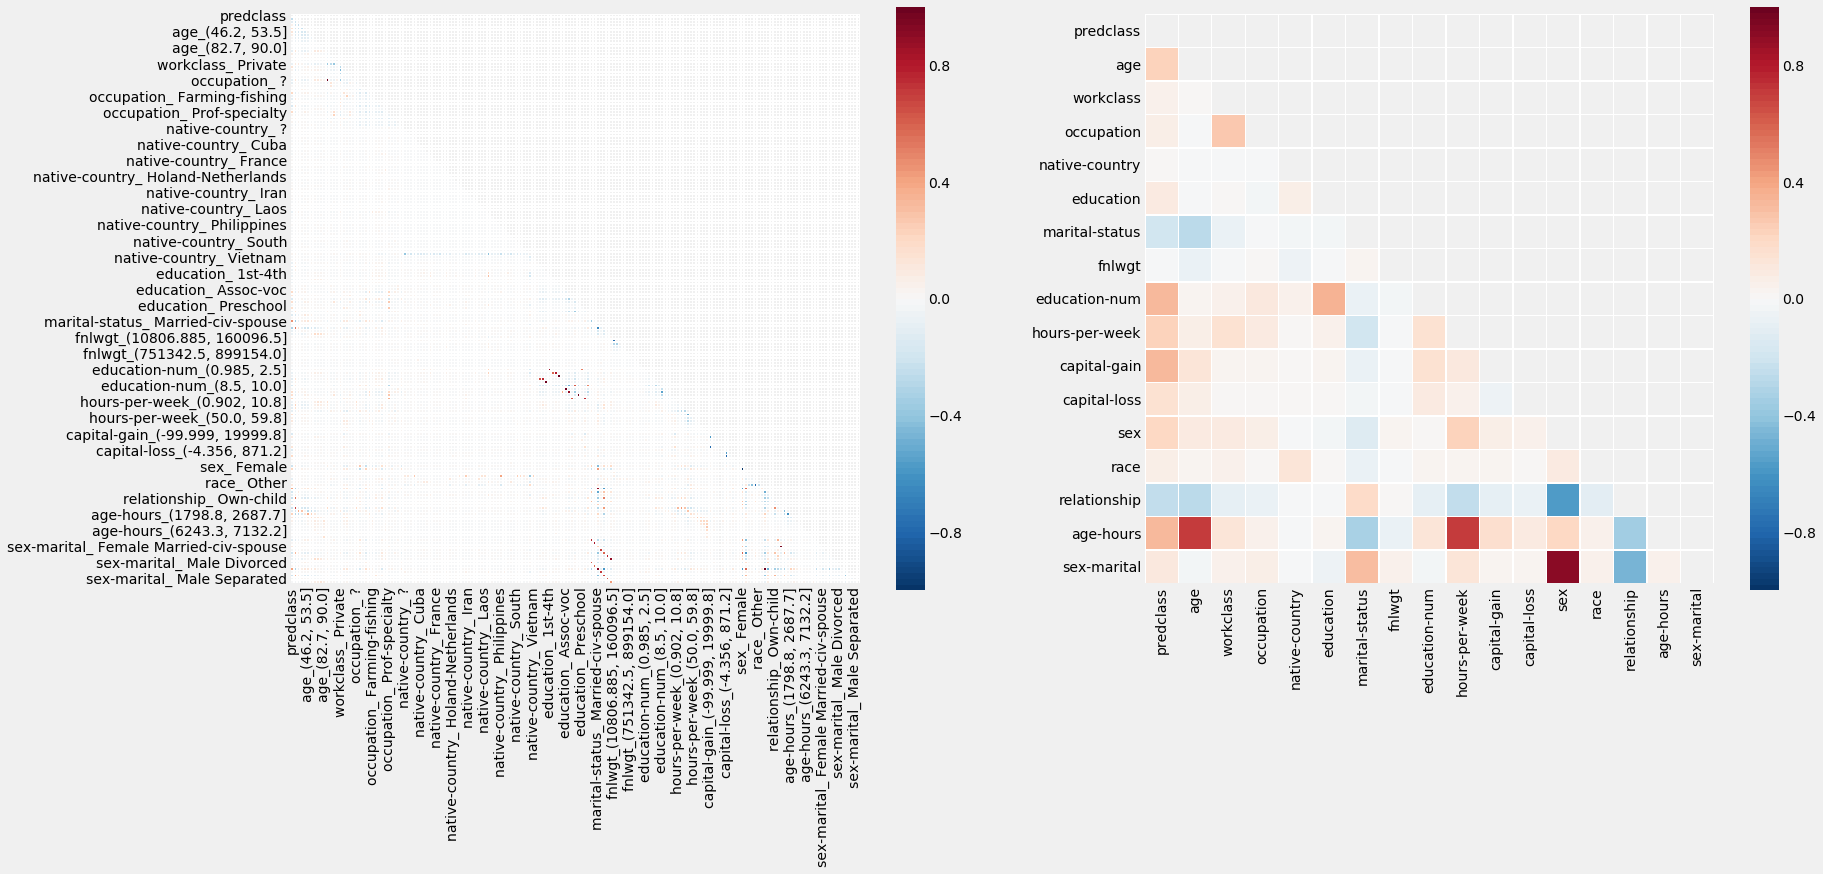

In [96]:
# Create a correlation plot of both datasets.
fig = plt.figure(figsize=(25,10)) 
plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);
plt.subplot(1, 2, 2)

mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

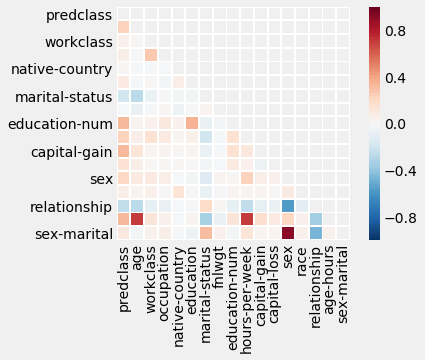

In [97]:
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.9);

In [98]:
dataset_con_enc.shape

(48842, 17)

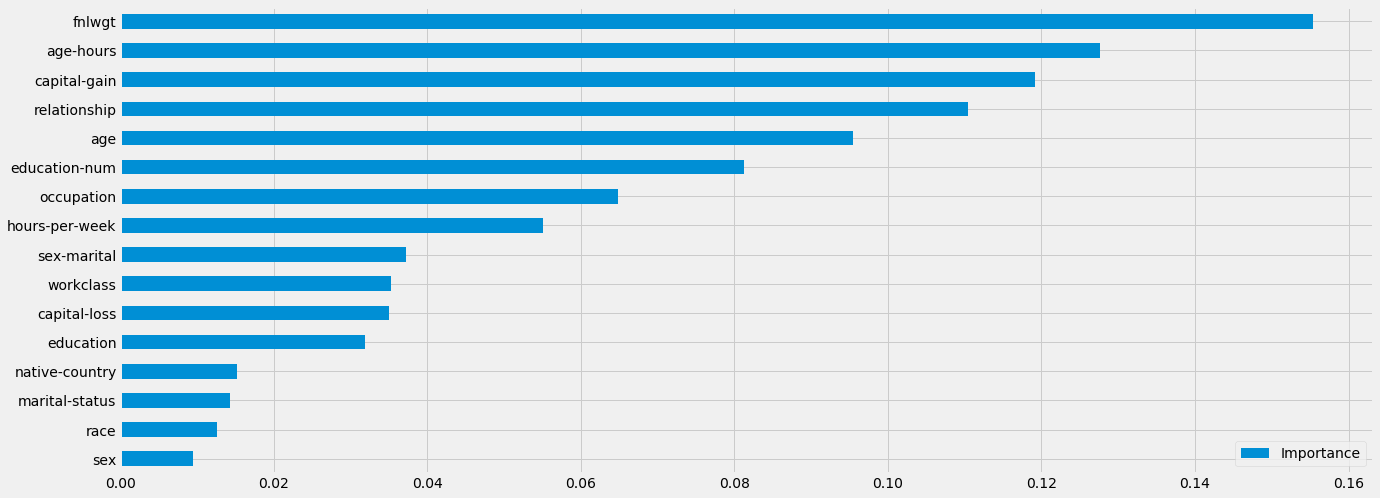

In [99]:
# Use Random Forest to get an insight on Feature Importance
clf = RandomForestClassifier()
plt.style.use('fivethirtyeight')
clf.fit(dataset_con_enc.drop('predclass', axis=1), dataset_con_enc['predclass'])
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('predclass', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

In [100]:
dataset_bin_enc.head()

predclass  age_(16.927, 24.3]  age_(24.3, 31.6]  age_(31.6, 38.9]  \
0          0                   0                 0                 0   
1          0                   0                 0                 0   
2          0                   0                 0                 1   
3          0                   0                 0                 0   
4          0                   0                 1                 0   

   age_(38.9, 46.2]  age_(46.2, 53.5]  age_(53.5, 60.8]  age_(60.8, 68.1]  \
0                 1                 0                 0                 0   
1                 0                 1                 0                 0   
2                 0                 0                 0                 0   
3                 0                 1                 0                 0   
4                 0                 0                 0                 0   

   age_(68.1, 75.4]  age_(75.4, 82.7]            ...              \
0                 0                 0            ...               
1                 0                 0            ...               
2                 0                 0            ...               
3                 0                 0            ...               
4                 0                 0            ...               

   sex-marital_ Female Never-married  sex-marital_ Female Separated  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   

   sex-marital_ Female Widowed  sex-marital_ Male Divorced  \
0                            0                           0   
1                            0                           0   
2                            0                           1   
3                            0                           0   
4                            0                           0   

   sex-marital_ Male Married-AF-spouse  sex-marital_ Male Married-civ-spouse  \
0                                    0                                     0   
1                                    0                                     1   
2                                    0                                     0   
3                                    0                                     1   
4                                    0                                     0   

   sex-marital_ Male Married-spouse-absent  sex-marital_ Male Never-married  \
0                                        0                                1   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   

   sex-marital_ Male Separated  sex-marital_ Male Widowed  
0                            0                          0  
1                            0                          0  
2                            0                          0  
3                            0                          0  
4                            0                          0  

[5 rows x 177 columns]

In [101]:
dataset_bin_enc.shape

(48842, 177)

In [107]:
77*5*50 #[80:20]

19250

In [108]:
0.80*19250

15400.0

In [109]:
# How to reduce features by applying PCA

In [111]:
#apply standard scaler
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
std_scale

StandardScaler(copy=True, with_mean=True, with_std=True)

In [112]:
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))

In [113]:
X.shape

(48842, 176)

In [114]:
#apply PCA
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
pca1

PCA(copy=True, iterated_power='auto', n_components=176, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [115]:
fit1 = pca1.fit(X)
fit1

PCA(copy=True, iterated_power='auto', n_components=176, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [116]:
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
std_scale

StandardScaler(copy=True, with_mean=True, with_std=True)

In [117]:
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
X

array([[ 0.02599598,  2.13735875, -1.3184598 , ..., -0.2766849 ,
         0.06278054,  1.07467973],
       [ 0.82830842,  1.45440066, -0.60931809, ..., -0.9008521 ,
        -1.34611536,  0.49406607],
       [-0.04694151,  0.08848448, -0.13655694, ..., -0.2766849 ,
         0.01594744, -0.0865476 ],
       ...,
       [-0.04694151,  0.08848448,  0.80896535, ..., -0.9008521 ,
         0.54281987,  0.49406607],
       [ 0.39068346,  0.08848448, -1.3184598 , ...,  0.97164949,
         0.33987641, -0.0865476 ],
       [-0.26575399,  0.77144257, -0.60931809, ..., -0.9008521 ,
         0.79259643,  0.49406607]])

In [118]:
X.shape

(48842, 16)

In [120]:
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
pca2

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [121]:
fit2 = pca2.fit(X)
fit2

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

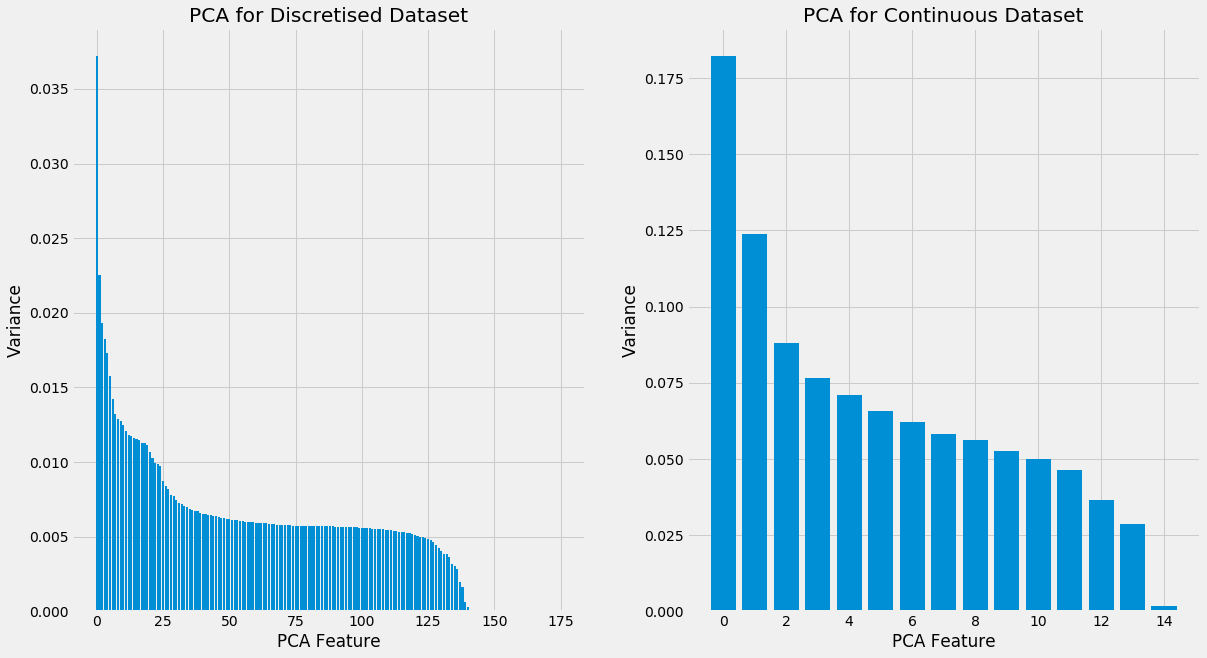

In [122]:
# Graphing the variance per feature
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18,10)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

In [139]:
np.round(fit1.explained_variance_ratio_,2)

array([0.04, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [140]:
np.round(fit2.explained_variance_ratio_,2)

array([0.18, 0.12, 0.09, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05,
       0.05, 0.04, 0.03, 0.  ])

In [ ]:
# show PCA results in 3 Dimensional Scenario

In [123]:
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
std_scale

StandardScaler(copy=True, with_mean=True, with_std=True)

In [124]:
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
X

array([[ 0.02599598,  2.13735875, -1.3184598 , ..., -0.2766849 ,
         0.06278054,  1.07467973],
       [ 0.82830842,  1.45440066, -0.60931809, ..., -0.9008521 ,
        -1.34611536,  0.49406607],
       [-0.04694151,  0.08848448, -0.13655694, ..., -0.2766849 ,
         0.01594744, -0.0865476 ],
       ...,
       [-0.04694151,  0.08848448,  0.80896535, ..., -0.9008521 ,
         0.54281987,  0.49406607],
       [ 0.39068346,  0.08848448, -1.3184598 , ...,  0.97164949,
         0.33987641, -0.0865476 ],
       [-0.26575399,  0.77144257, -0.60931809, ..., -0.9008521 ,
         0.79259643,  0.49406607]])

In [125]:
y = dataset_con_enc['predclass']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: predclass, dtype: int64

In [126]:
# PCA's components graphed in 2D and 3D
# Apply Scaling 
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

In [127]:
# Formatting
target_names = [0,1]
colors = ['blue','orange']
lw = 2
alpha = 0.3

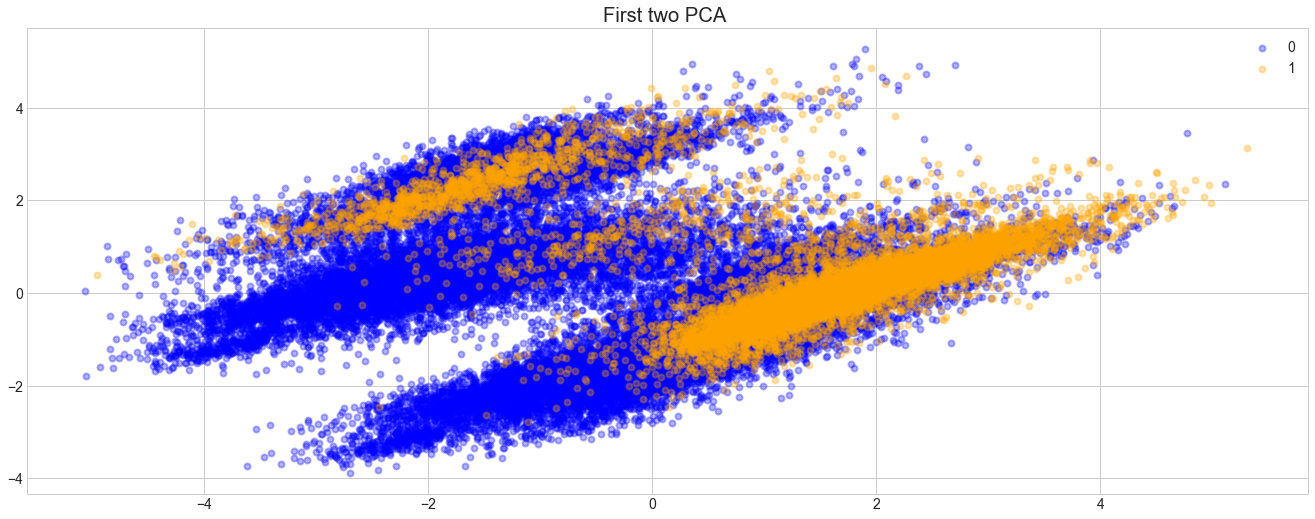

In [128]:
# 2 Components PCA
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(45, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA ');


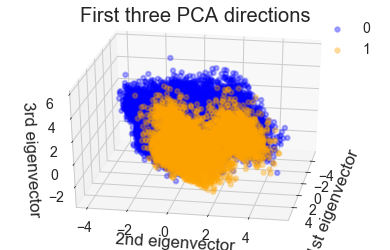

In [129]:
# 3 Components PCA
ax = plt.subplot(1, 1, 1, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")
# rotate the axes
ax.view_init(30, 10)

In [146]:
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(dataset_con_enc.drop('predclass', axis=1).values, dataset_con_enc['predclass'].values)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)

Feature Ranking For Non-Discretised: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Optimal number of features : 14


In [147]:
selector1

RFECV(cv=5,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring=None, step=1, verbose=0)

In [148]:
dataset_con_enc.shape

(48842, 15)

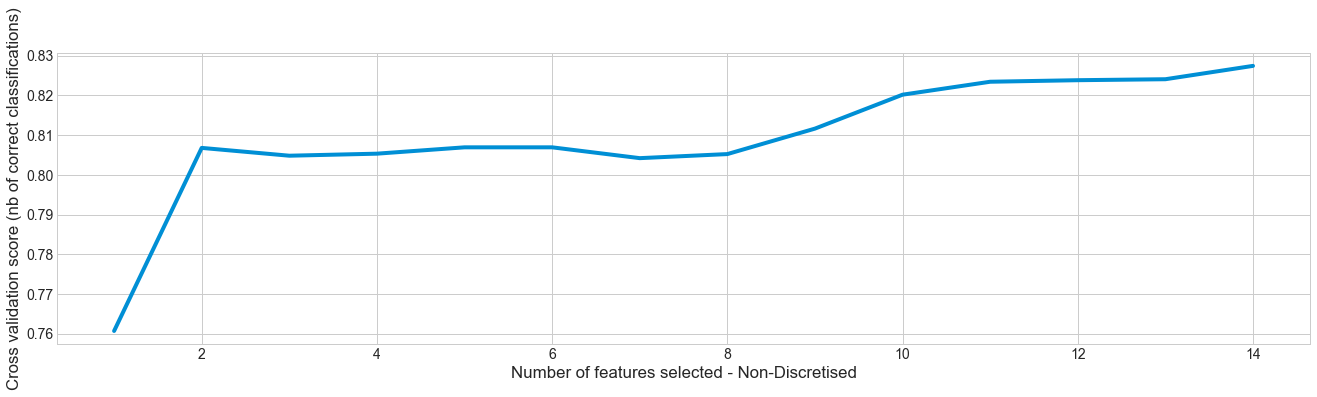

In [149]:
# Plot number of features VS. cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_);

In [150]:
dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector1.support_, 0, True)]]
dataset_con_enc

predclass  age  workclass  occupation  education  marital-status  \
0              0   22          7           1          9               4   
1              0   33          6           4          9               2   
2              0   21          4           6         11               0   
3              0   36          4           6          1               2   
4              0   11          4          10          9               2   
5              0   20          4           4         12               2   
6              0   32          4           8          6               3   
7              1   35          6           4         11               2   
8              1   14          4          10         12               4   
9              1   25          4           4          9               2   
10             1   20          4           4         15               2   
11             1   13          7          10          9               2   
12             0    6          4           1          9               4   
13             0   15          4          12          7               4   
14             1   23          4           3          8               2   
15             0   17          4          14          5               2   
16             0    8          6           5         11               4   
17             0   15          4           7         11               4   
18             0   21          4          12          1               2   
19             1   26          6           4         12               0   
20             1   23          4          10         10               2   
21             0   37          4           8         11               5   
22             0   18          1           5          6               2   
23             0   26          4          14          1               2   
24             0   42          4          13         11               0   
25             1   39          2          13          9               2   
26             0    2          4           3         11               4   
27             1   37          0           0         15               2   
28             0   22          4           4         11               0   
29             0   32          4           3         11               2   
...          ...  ...        ...         ...        ...             ...   
48813          0   64          0           0          8               2   
48814          1   43          4          10          8               2   
48815          0   22          4          13          9               4   
48816          1   21          4          10         12               2   
48817          1   26          2           4         12               2   
48818          0    6          4           7         11               4   
48819          0   56          5           4         15               0   
48820          0   18          4          11         15               2   
48821          0   49          4          12         11               6   
48822          0   10          4          12         15               4   
48823          1   23          4          10         14               2   
48824          0   34          4           3         11               2   
48825          0    5          4           3         15               4   
48826          0   47          6           5         11               6   
48827          1   33          2          10         12               2   
48828          0   38          4           9         11               5   
48829          0   21          4           1          8               4   
48830          0   41          4          10          7               0   
48831          0   15          4           6         11               2   
48832          0   31          4           1         11               2   
48833          0   44          4          12         11               2   
48834          0   14          4

In [151]:
selected_dataset = dataset_con_enc

selected_dataset.head(2)

predclass  age  workclass  occupation  education  marital-status  \
0          0   22          7           1          9               4   
1          0   33          6           4          9               2   

   education-num  hours-per-week  capital-gain  capital-loss  sex  race  \
0             12              39            27             0    1     4   
1             12              12             0             0    1     4   

   relationship  age-hours  sex-marital  
0             1        695           11  
1             0        334            9

In [154]:
# Splitting the Training and Test data sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(selected_dataset,test_size=0.20,random_state=1234)


In [155]:
train.head()

predclass  age  workclass  occupation  education  marital-status  \
32722          0   38          4           8          1               2   
36171          0    6          4           8         15               4   
19838          0    7          6          14         15               2   
4878           1   29          4           4         15               2   
45985          0   30          2          10          9               4   

       education-num  hours-per-week  capital-gain  capital-loss  sex  race  \
32722              6              29             0             0    1     4   
36171              9              39             0             0    1     4   
19838              9              59             0             0    1     4   
4878               9              39             0             0    0     4   
45985             12              49             0             0    0     4   

       relationship  age-hours  sex-marital  
32722             0        726            9  
36171             3        445           11  
19838             0        654            9  
4878              5        796            2  
45985             1        964            4

In [156]:
test.head()

predclass  age  workclass  occupation  education  marital-status  \
48406          0   20          4           6         15               2   
39568          0   25          4           1         15               0   
8866           0   40          6           5          7               3   
47147          0   40          6           1         11               2   
29582          0    6          0           0         15               4   

       education-num  hours-per-week  capital-gain  capital-loss  sex  race  \
48406              9              39             0             0    1     3   
39568              9              39             0             0    0     4   
8866              11              39             0             0    1     0   
47147              8              15             0             0    0     4   
29582              9              29             0             0    1     4   

       relationship  age-hours  sex-marital  
48406             0        669            9  
39568             4        738            0  
8866              4        943           10  
47147             5        442            2  
29582             3        351           11

In [157]:
#drop the na values
train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [158]:
X_train_w_label = train
X_train = train.drop(['predclass'], axis=1)
y_train = train['predclass'].astype('int64')
X_test  = test.drop(['predclass'], axis=1)
y_test  = test['predclass'].astype('int64')

In [159]:
X_train.shape

(39073, 14)

In [160]:
X_train.head()

age  workclass  occupation  education  marital-status  education-num  \
32722   38          4           8          1               2              6   
36171    6          4           8         15               4              9   
19838    7          6          14         15               2              9   
4878    29          4           4         15               2              9   
45985   30          2          10          9               4             12   

       hours-per-week  capital-gain  capital-loss  sex  race  relationship  \
32722              29             0             0    1     4             0   
36171              39             0             0    1     4             3   
19838              59             0             0    1     4             0   
4878               39             0             0    0     4             5   
45985              49             0             0    0     4             1   

       age-hours  sex-marital  
32722        726            9  
36171        445           11  
19838        654            9  
4878         796            2  
45985        964            4

In [161]:
y_train.head()

32722    0
36171    0
19838    0
4878     1
45985    0
Name: predclass, dtype: int64

In [162]:
random.seed(1)

In [163]:
# Modeling Step

## Select Candidate Algorithms

### 1. KNN
### 2. Logistic Regression
### 3. Random Forest
### 4. Naive Bayes
### 5. Stochastic Gradient Decent
### 6. Linear SVC
### 7. Decision Tree
### 8. Gradient Boosted Trees

In [164]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [165]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [166]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            


In [167]:
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}



In [168]:
# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 314.30 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.826 (std: 0.003)
Parameters: {'penalty': 'l1', 'intercept_scaling': 0.00010413620821135999, 'class_weight': None, 'C': 5.244112105392491e+16}

Model with rank: 2
Mean validation score: 0.821 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.1700564652505462e-18, 'class_weight': None, 'C': 1219.8561803315788}

Model with rank: 2
Mean validation score: 0.821 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 5.45850493607753e-10, 'class_weight': None, 'C': 1.2814768678715739e+17}

Model with rank: 4
Mean validation score: 0.772 (std: 0.002)
Parameters: {'penalty': 'l1', 'intercept_scaling': 5382364400.3247385, 'class_weight': 'balanced', 'C': 2.1869254739330048e+18}

Model with rank: 5
Mean validation score: 0.767 (std: 0.003)
Parameters: {'penalty': 'l1', 'intercept_scaling': 25529405647.455635, 'class_weight': 'balanced', 'C': 63034738862

In [169]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 81.94
Accuracy CV 10-Fold: 82.94
Running Time: 0:00:05.773071


In [170]:
print (metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     29771
           1       0.72      0.46      0.56      9302

    accuracy                           0.83     39073
   macro avg       0.78      0.70      0.73     39073
weighted avg       0.82      0.83      0.82     39073



In [171]:
print (metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7384
           1       0.71      0.44      0.55      2385

    accuracy                           0.82      9769
   macro avg       0.77      0.69      0.72      9769
weighted avg       0.81      0.82      0.80      9769



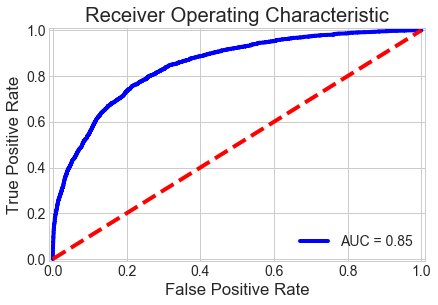

In [172]:
plot_roc_curve(y_test, probs_log)

In [173]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 80.4
Accuracy CV 10-Fold: 80.74
Running Time: 0:00:04.129114


In [174]:
print (metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     29771
           1       0.60      0.57      0.59      9302

    accuracy                           0.81     39073
   macro avg       0.73      0.73      0.73     39073
weighted avg       0.80      0.81      0.81     39073



In [175]:
print (metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7384
           1       0.60      0.58      0.59      2385

    accuracy                           0.80      9769
   macro avg       0.73      0.73      0.73      9769
weighted avg       0.80      0.80      0.80      9769



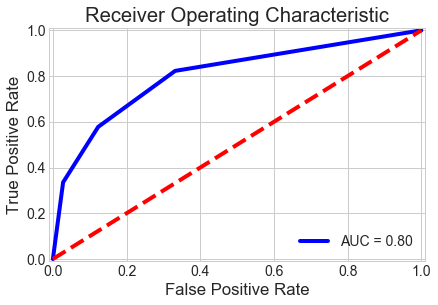

In [176]:
plot_roc_curve(y_test, probs_knn)

In [177]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 80.91
Accuracy CV 10-Fold: 81.65
Running Time: 0:00:00.399057


In [178]:
print (metrics.classification_report(y_train, train_pred_gaussian)) 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     29771
           1       0.61      0.63      0.62      9302

    accuracy                           0.82     39073
   macro avg       0.75      0.75      0.75     39073
weighted avg       0.82      0.82      0.82     39073



In [179]:
print (metrics.classification_report(y_test, test_pred_gaussian)) 

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7384
           1       0.61      0.61      0.61      2385

    accuracy                           0.81      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.81      0.81      0.81      9769



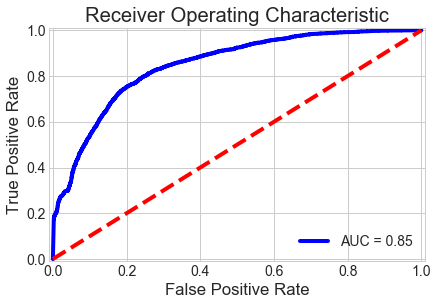

In [180]:
plot_roc_curve(y_test, probs_gau)

In [181]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 75.64
Accuracy CV 10-Fold: 76.86
Running Time: 0:00:54.672754


In [182]:
print (metrics.classification_report(y_train, train_pred_svc))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     29771
           1       0.53      0.29      0.37      9302

    accuracy                           0.77     39073
   macro avg       0.67      0.60      0.62     39073
weighted avg       0.74      0.77      0.74     39073



In [183]:
print (metrics.classification_report(y_test, test_pred_svc)) 

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7384
           1       0.86      0.00      0.01      2385

    accuracy                           0.76      9769
   macro avg       0.81      0.50      0.43      9769
weighted avg       0.78      0.76      0.65      9769



In [184]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 81.14
Accuracy CV 10-Fold: 79.57
Running Time: 0:00:06.969328


In [185]:
print (metrics.classification_report(y_train, train_pred_sgd)) 

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     29771
           1       0.61      0.39      0.48      9302

    accuracy                           0.80     39073
   macro avg       0.72      0.66      0.67     39073
weighted avg       0.78      0.80      0.78     39073



In [186]:
print (metrics.classification_report(y_test, test_pred_sgd)) 

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7384
           1       0.62      0.59      0.61      2385

    accuracy                           0.81      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.81      0.81      0.81      9769



In [187]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 82.11
Accuracy CV 10-Fold: 82.06
Running Time: 0:00:01.125759


In [188]:
print (metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     29771
           1       0.63      0.61      0.62      9302

    accuracy                           0.82     39073
   macro avg       0.75      0.75      0.75     39073
weighted avg       0.82      0.82      0.82     39073



In [189]:
print (metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7384
           1       0.64      0.61      0.62      2385

    accuracy                           0.82      9769
   macro avg       0.76      0.75      0.75      9769
weighted avg       0.82      0.82      0.82      9769



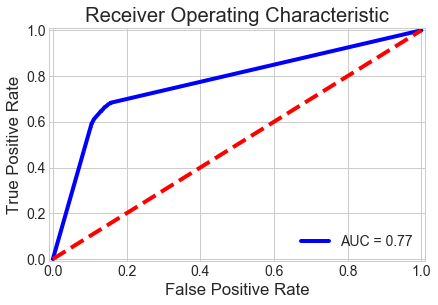

In [190]:
plot_roc_curve(y_test, probs_dt)

In [191]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


In [192]:
# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 6.97 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.860 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 14}

Model with rank: 2
Mean validation score: 0.860 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 4, 'min_samples_split': 16}

Model with rank: 3
Mean validation score: 0.860 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 14}

Model with rank: 4
Mean validation score: 0.860 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 9}

Model with rank: 5
Mean validation score: 0.860 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', '

In [193]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 85.54
Accuracy CV 10-Fold: 85.96
Running Time: 0:00:05.764080


In [194]:
print (metrics.classification_report(y_train, train_pred_rf)) 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     29771
           1       0.75      0.62      0.68      9302

    accuracy                           0.86     39073
   macro avg       0.82      0.78      0.79     39073
weighted avg       0.85      0.86      0.86     39073



In [195]:
print (metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7384
           1       0.74      0.63      0.68      2385

    accuracy                           0.86      9769
   macro avg       0.81      0.78      0.79      9769
weighted avg       0.85      0.86      0.85      9769



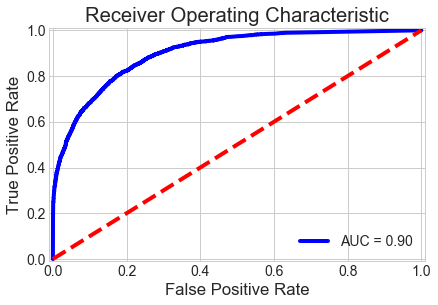

In [196]:
plot_roc_curve(y_test, probs_rf)

In [197]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.25
Accuracy CV 10-Fold: 86.66
Running Time: 0:00:20.827740


In [198]:
print (metrics.classification_report(y_train, train_pred_gbt)) 

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     29771
           1       0.79      0.60      0.68      9302

    accuracy                           0.87     39073
   macro avg       0.84      0.78      0.80     39073
weighted avg       0.86      0.87      0.86     39073



In [199]:
print (metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7384
           1       0.78      0.61      0.68      2385

    accuracy                           0.86      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769



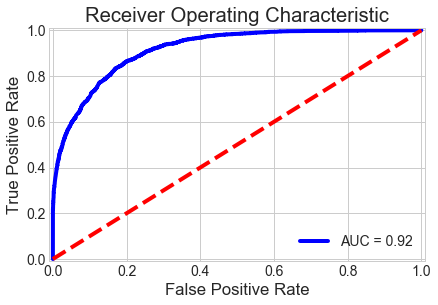

In [200]:
plot_roc_curve(y_test, probs_gbt)

In [201]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

Model  Score
7     Gradient Boosting Trees  86.25
2               Random Forest  85.54
6               Decision Tree  82.11
1         Logistic Regression  81.94
4  Stochastic Gradient Decent  81.14
3                 Naive Bayes  80.91
0                         KNN  80.40
5                  Linear SVC  75.64

In [202]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

Model  Score
7     Gradient Boosting Trees  86.66
2               Random Forest  85.96
1         Logistic Regression  82.94
6               Decision Tree  82.06
3                 Naive Bayes  81.65
0                         KNN  80.74
4  Stochastic Gradient Decent  79.57
5                  Linear SVC  76.86

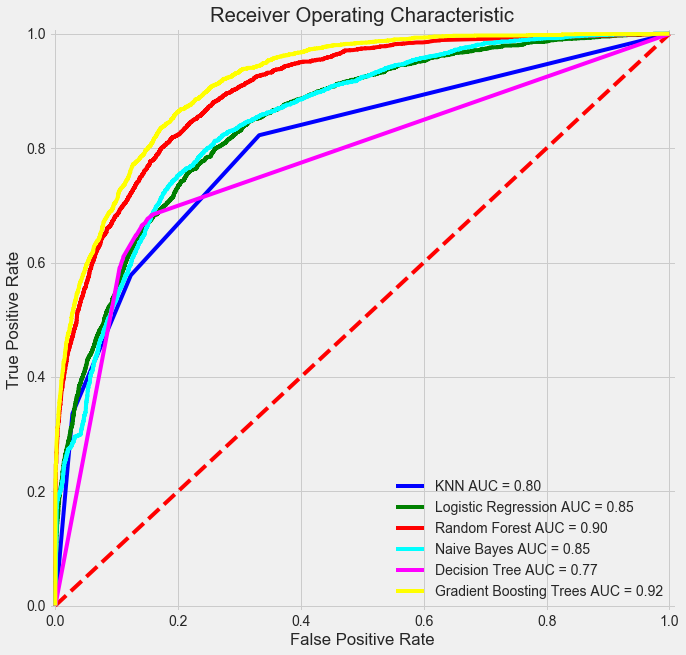

In [206]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
    
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt,

]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()

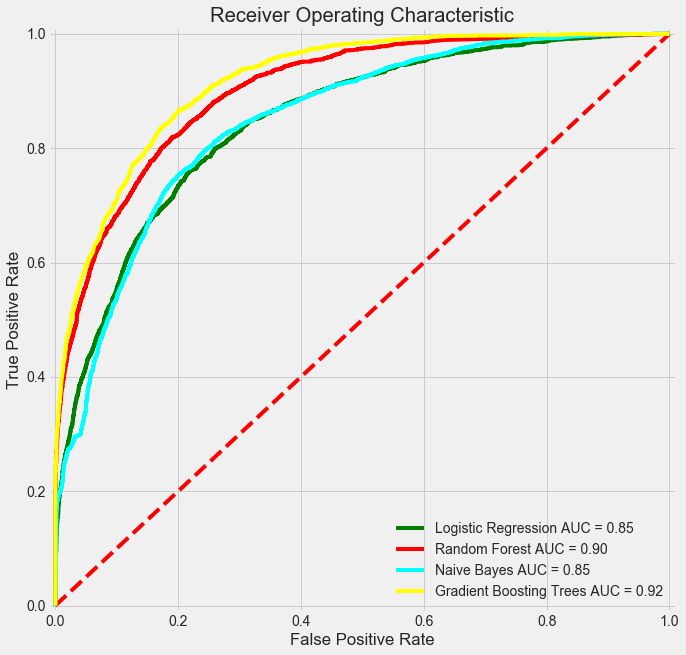

In [207]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,10)) 

models = [
    #'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    #'Decision Tree', 
    'Gradient Boosting Trees'
    
]
probs = [
    #probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    #probs_dt,
    probs_gbt,

]
colors = [
    #'blue',
    'green',
    'red',
    'cyan',
    #'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()

In [209]:
test_pred_log

array([0, 0, 0, ..., 0, 0, 0])

In [210]:
test_pred_rf

array([0, 0, 0, ..., 0, 0, 0])

In [211]:
test_pred_gaussian

array([0, 0, 0, ..., 0, 0, 0])

In [212]:
test_pred_gbt

array([0, 0, 0, ..., 0, 0, 0])

In [226]:
act_y = pd.DataFrame(np.array(y_test),index=None)

In [227]:
final_result = pd.concat([pd.Series(test_pred_log),pd.Series(test_pred_rf),pd.Series(test_pred_gaussian),
                         pd.Series(test_pred_gbt),act_y],axis=1)

In [228]:
final_result.head(10)

0  1  2  3  0
0  0  0  0  0  0
1  0  0  0  0  0
2  0  0  0  0  0
3  0  0  0  0  0
4  0  0  0  0  0
5  0  0  0  0  0
6  0  0  0  0  0
7  0  0  1  0  0
8  0  0  1  0  1
9  0  0  1  0  1

In [229]:
final_result.columns = ['log','rf','nb','gbt','actY']

In [230]:
final_result.head()

log  rf  nb  gbt  actY
0    0   0   0    0     0
1    0   0   0    0     0
2    0   0   0    0     0
3    0   0   0    0     0
4    0   0   0    0     0

In [235]:
np.where(final_result.sum(axis=1) > 0)

(array([   7,    8,    9, ..., 9756, 9758, 9762]),)

In [238]:
final_result.to_csv('model_stacking.csv')